# Compare tau decay distributions between Tauola and IceCube simulations

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import load_hepmc, plot_histograms, filter_events, load_hepmc_tau
from collections import Counter
import numba
import pyhepmc
import vector

## Load decays

In [73]:
nutau_energies = [5, 10, 20, 50, 100] # GeV

# decay_products = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output.dat") for e in nutau_energies}
# decay_products_boost = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output-b.dat") for e in nutau_energies}
decay_products_nopol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_nopol.dat") for e in nutau_energies}
decay_products_lpol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_lpol.dat") for e in nutau_energies}
# decay_products_ic = {e: pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv") for e in nutau_energies}
# decay_products_pythia = {e: pd.read_csv(f"../data/pythia_tau_decays_e{e}.csv") for e in nutau_energies}

0
10000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000
70000
0
10000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000
70000


In [74]:
decay_products_pythia_nopol = {e: pd.read_csv(f"../data/pythia_tau_decays_e{e}_nopol.csv") for e in nutau_energies}
decay_products_pythia_lpol = {e: pd.read_csv(f"../data/pythia_tau_decays_e{e}_lpol.csv") for e in nutau_energies}

In [97]:
tau_only_nopol_df = load_hepmc("../data/tau_decays_159007_tauola_output_nopol.dat")
tau_only_lpol_df = load_hepmc("../data/tau_decays_159007_tauola_output_lpol.dat")

tau_only_pythia_nopol_df = pd.read_csv("../data/pythia_tau_decays_etau_nopol.csv")
tau_only_pythia_lpol_df = pd.read_csv("../data/pythia_tau_decays_etau_lpol.csv")

0
10000
20000
30000
0
10000
20000
30000


In [99]:
# Sanity check that there are only dicrete energies of the tau leptons
for df in (tau_only_lpol_df, tau_only_nopol_df, tau_only_pythia_lpol_df, tau_only_pythia_nopol_df):
    assert df.query("pdg == 15")["E"].unique().shape[0] == 4
    assert (df.groupby("event_num").nth(2)["pdg"] == 15).all()

assert all(
    (np.sort(tau_only_nopol_df["event_num"].unique()) == np.sort(a["event_num"].unique())).all() 
    for a in (tau_only_nopol_df, tau_only_lpol_df, tau_only_pythia_nopol_df, tau_only_pythia_lpol_df)
)

tau_only_lpol = {}
tau_only_nopol = {}
tau_only_pythia_lpol = {}
tau_only_pythia_nopol = {}

for e, df in tau_only_lpol_df.query("pdg == 15").groupby("E", as_index=False):
    print(e)
    event_nums = df["event_num"].unique()
    tau_only_lpol[e] = tau_only_lpol_df[tau_only_lpol_df["event_num"].isin(event_nums)]
    tau_only_nopol[e] = tau_only_nopol_df[tau_only_nopol_df["event_num"].isin(event_nums)]
    tau_only_pythia_lpol[e] = tau_only_pythia_lpol_df[tau_only_pythia_lpol_df["event_num"].isin(event_nums)]
    tau_only_pythia_nopol[e] = tau_only_pythia_nopol_df[tau_only_pythia_nopol_df["event_num"].isin(event_nums)]


for d in (tau_only_lpol, tau_only_nopol, tau_only_pythia_lpol, tau_only_pythia_nopol):
    for e, df in d.items():
        assert df.query("pdg == 15")["E"].nunique() == 1

nutau_energies = list(tau_only_lpol.keys())

2.77682
6.77682
11.77682
101.77682


In [100]:
datasets = {
    # "Tauola polarized (boosted)": decay_products_boost, 
    # "Tauola polarized (rest frame)": decay_products, 
    # "Tauola left-handed": decay_products_lpol,
    # "Tauola unpolarized": decay_products_nopol, 
    # "IceCube": decay_products_ic,
    # "Pythia unpolarized": decay_products_pythia_nopol,
    # "Pythia left-handed": decay_products_pythia_lpol,
    "Tauola fully polarized": tau_only_lpol,
    "Tauola unpolarized": tau_only_nopol,
    "Pythia fully polarized": tau_only_pythia_lpol,
    "Pythia unpolarized": tau_only_pythia_nopol
}

# add the polarization vector to all datasets
# for e in nutau_energies:
#     ref = datasets["IceCube"][e]
#     for label, d in datasets.items():
#         if label == "IceCube":
#             continue
    
#         d[e].loc[:, ["polx", "poly", "polz"]] = np.nan
#         d[e].loc[d[e].pdg == 15, ["polx", "poly", "polz"]] = ref.loc[ref.pdg == 15, ["polx", "poly", "polz"]].values 

In [102]:
with pyhepmc.open("../data/tau_decays_159007_tauola_output_nopol.dat", "r") as f:
    evt = f.read()
    evt2 = f.read()
    evt3 = f.read()

In [103]:
evt

<GenEvent momentum_unit=1, length_unit=0, event_number=0, particles=6, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [104]:
evt2

<GenEvent momentum_unit=1, length_unit=0, event_number=1, particles=8, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [105]:
evt3

<GenEvent momentum_unit=1, length_unit=0, event_number=2, particles=6, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [109]:
tau_only_lpol[2.77682].head(12)

,event_num,pdg,E,px,py,pz
0,0,1000080160,0.000000,0.000000,0.000000,0.000000
1,0,16,0.000000,0.000000,0.000000,0.000000
2,0,15,2.776820,0.000000,0.000000,2.133926
3,0,16,2.110255,0.559376,-0.311570,2.010746
4,0,-211,0.666846,-0.559376,0.311570,0.123396
5,1,1000080160,0.000000,0.000000,0.000000,0.000000
6,1,16,0.000000,0.000000,0.000000,0.000000
7,1,15,2.776820,0.000000,0.000000,2.133926
8,1,16,0.718441,0.611596,0.141634,0.349211
9,1,-211,1.170034,-0.235845,0.268677,1.105301


## Compare IceCube decay products with Tauola decay products

In [64]:
def missing_energy(decay_products):
    decay_products_invisible = decay_products.groupby("event_num").nth[3:].query("(pdg.abs() == 12) or (pdg.abs() == 14) or (pdg.abs() == 16)")
    return decay_products_invisible.groupby("event_num")["E"].sum().values

Text(0.5, 0.98, 'Outgoing neutrino energy')

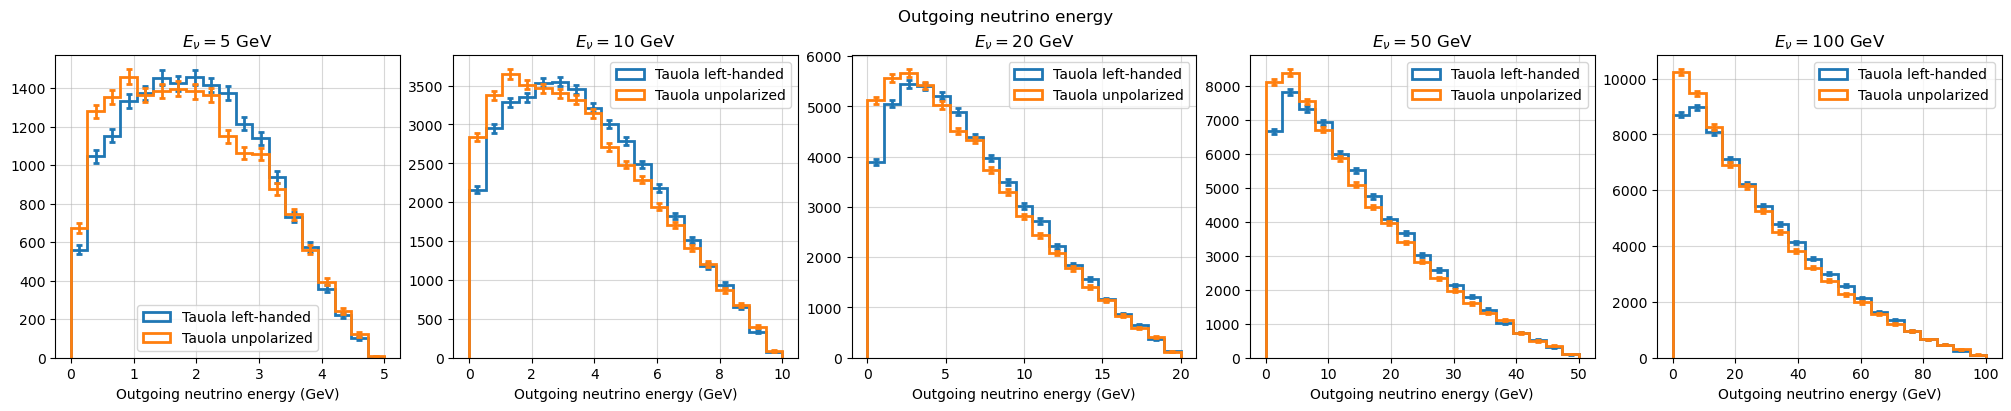

In [90]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=missing_energy,
    xlabel="Outgoing neutrino energy (GeV)", errorbar=True,
)
fig.suptitle("Outgoing neutrino energy")

Text(0.5, 0.98, 'Tau visible energy for all events')

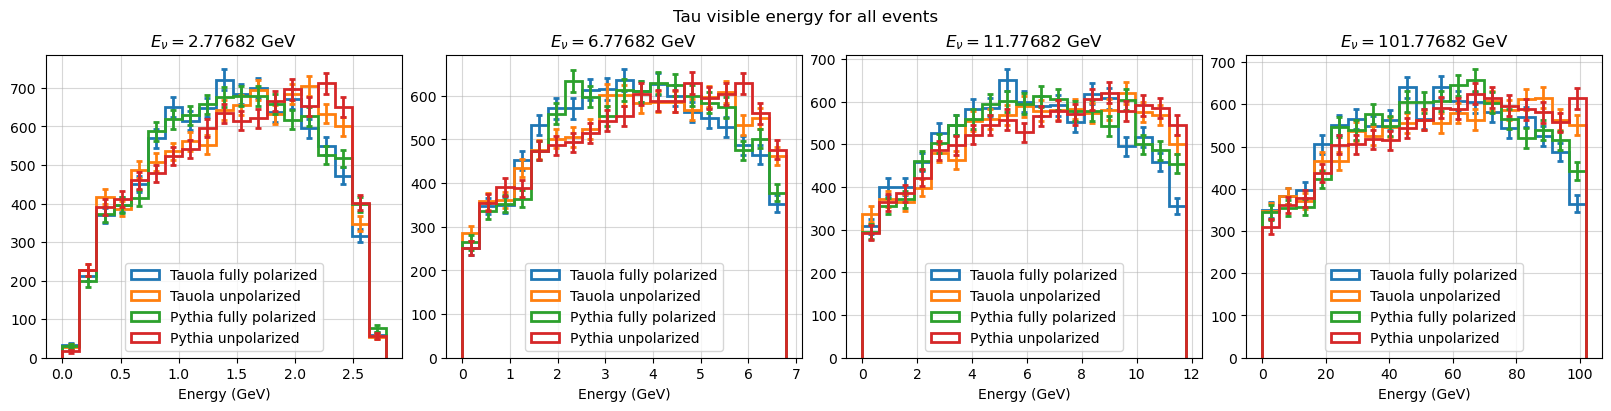

In [112]:
def tau_visible_e(df) -> np.ndarray:
    return df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum()

fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=tau_visible_e, 
    xlabel="Energy (GeV)", errorbar=True,
)
fig.suptitle(r"Tau visible energy for all events")

Text(0.5, 0.98, 'Tau visible energy fraction for all events')

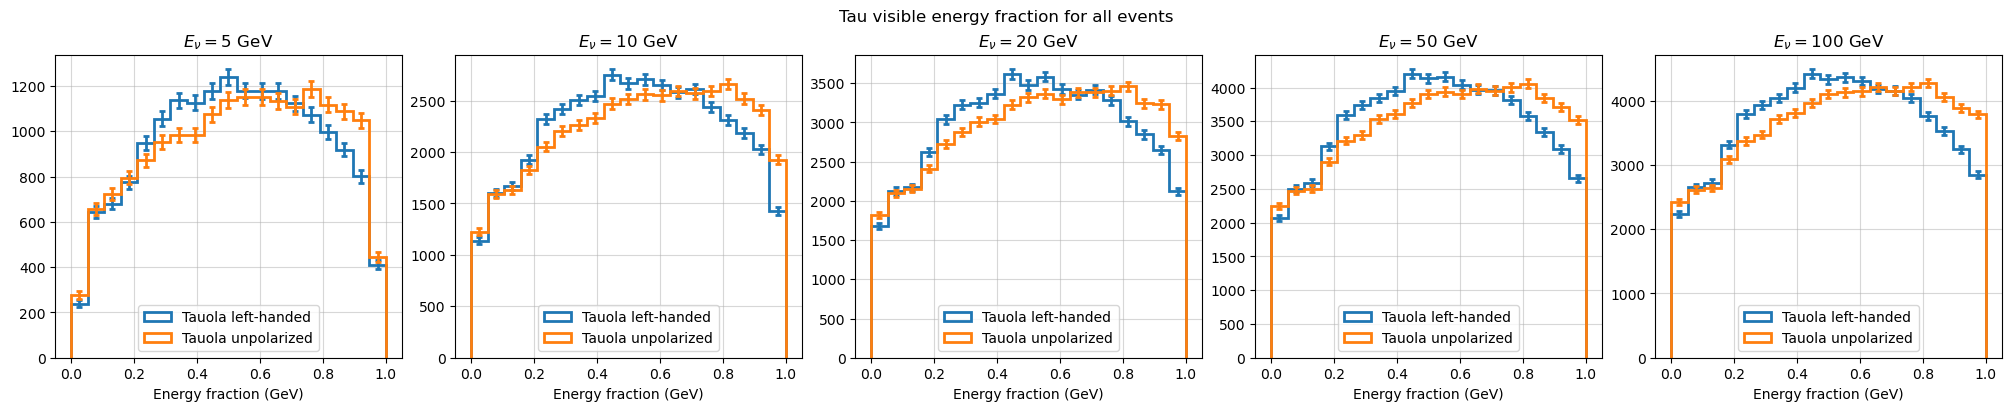

In [93]:
def tau_visible_e_fraction(df) -> np.ndarray:
    visible_e = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum().values
    total_e = df.query("pdg == 15")["E"].values
    return visible_e / total_e

fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=tau_visible_e_fraction, 
    xlabel="Energy fraction (GeV)", errorbar=True,
)
fig.suptitle(r"Tau visible energy fraction for all events")

In [94]:
def visible_theta(df) -> np.ndarray:
    """The angle between the combined 4-momentum of the visible particles and the z axis"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    p = np.sqrt(
        (
            visible_decay_products.groupby("event_num")[["px", "py", "pz"]]
            .sum() # Sum over all decay products
            **2 # Square each component
        ).sum(axis=1) # Sum over the components
    ) # Sqrt of the sum
    pz = visible_decay_products.groupby("event_num")["pz"].sum()
    return np.arccos(pz / np.sqrt(p**2))


def visible_theta_tau(df) -> np.ndarray:
    """The angle between the combined 4-momenta of the visible particles and the tau momentum"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    tau = df.query("pdg == 15").groupby("event_num")[["px", "py", "pz"]].sum()
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum()
    # ptau * pvisible / |ptau| * |pvisible|
    return np.arccos(
        (tau["px"] * visible["px"] + tau["py"] * visible["py"] + tau["pz"] * visible["pz"])
         / (np.sqrt((tau**2).sum(axis=1)) * np.sqrt((visible**2).sum(axis=1)))
    )

def visible_delta_theta_tau(df) -> np.ndarray:
    """The theta (angle relative to the incoming neutrino) difference between the tau and the visible tau.
    If it is a positive value, the tau is closer to the neutrino, while if it is a negative value, the visible tau is closer to the neutrino.
    """
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    tau = df.query("pdg == 15").groupby("event_num")[["px", "py", "pz"]].sum()
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum()
    tau_theta = np.arccos(tau["pz"] / np.sqrt((tau**2).sum(axis=1)))
    visible_theta = np.arccos(visible["pz"] / np.sqrt((visible**2).sum(axis=1)))
    return tau_theta - visible_theta

Text(0.5, 0.98, 'Tau visible angle relative to the incoming neutrino for all events')

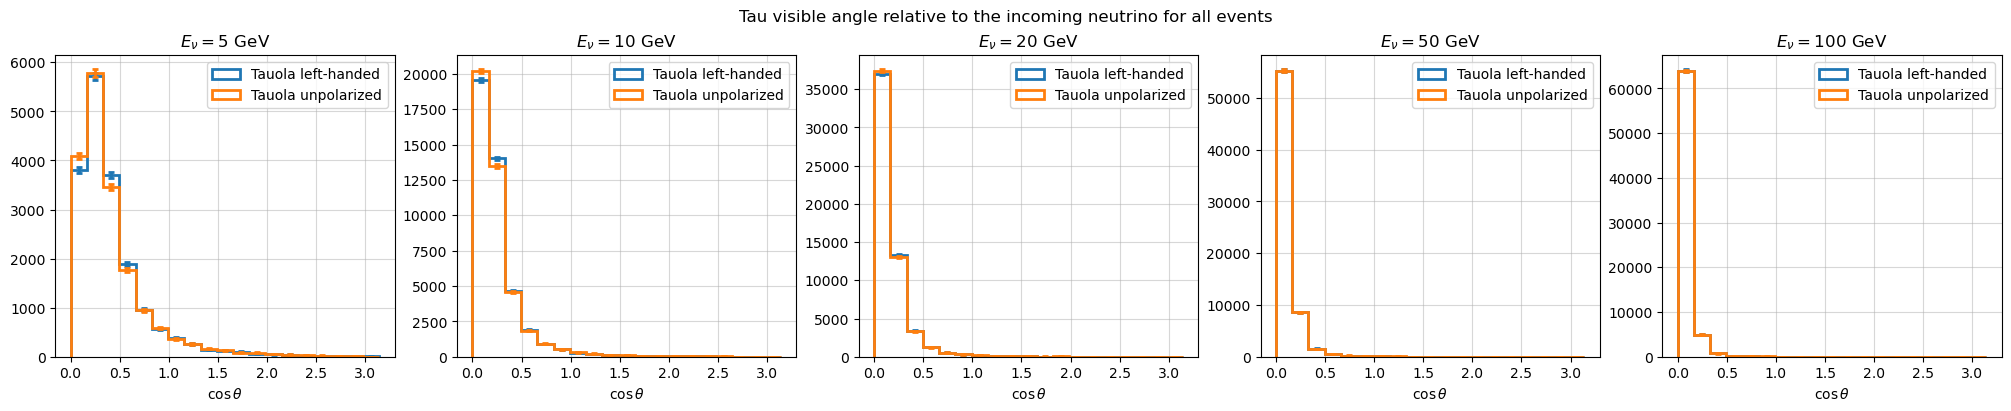

In [98]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=visible_theta, 
    xlabel=r"$\cos\theta$", errorbar=True,
)
fig.suptitle(r"Tau visible angle relative to the incoming neutrino for all events")

Text(0.5, 0.98, 'Angle between visible $\\tau$ and $\\tau$ for all events')

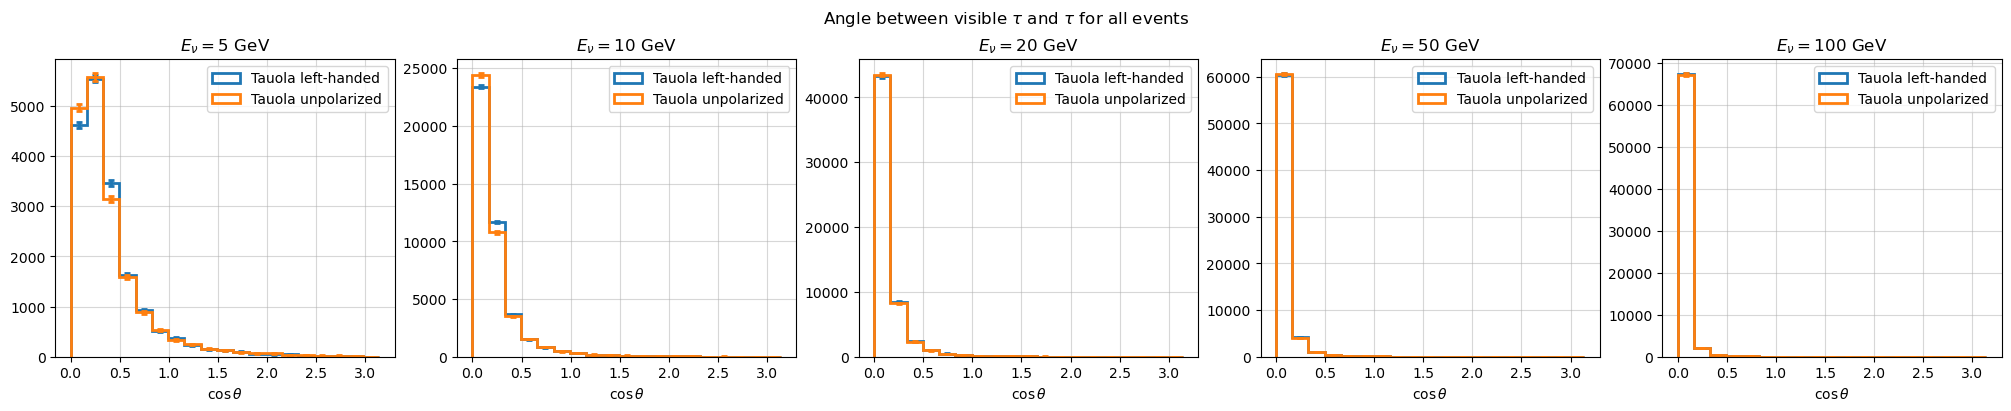

In [97]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=visible_theta_tau, 
    xlabel=r"$\cos\theta$", errorbar=True,
)
fig.suptitle(r"Angle between visible $\tau$ and $\tau$ for all events")

Text(0.5, 0.98, '$\\theta$ difference between $\\tau$ and visible $\\tau$')

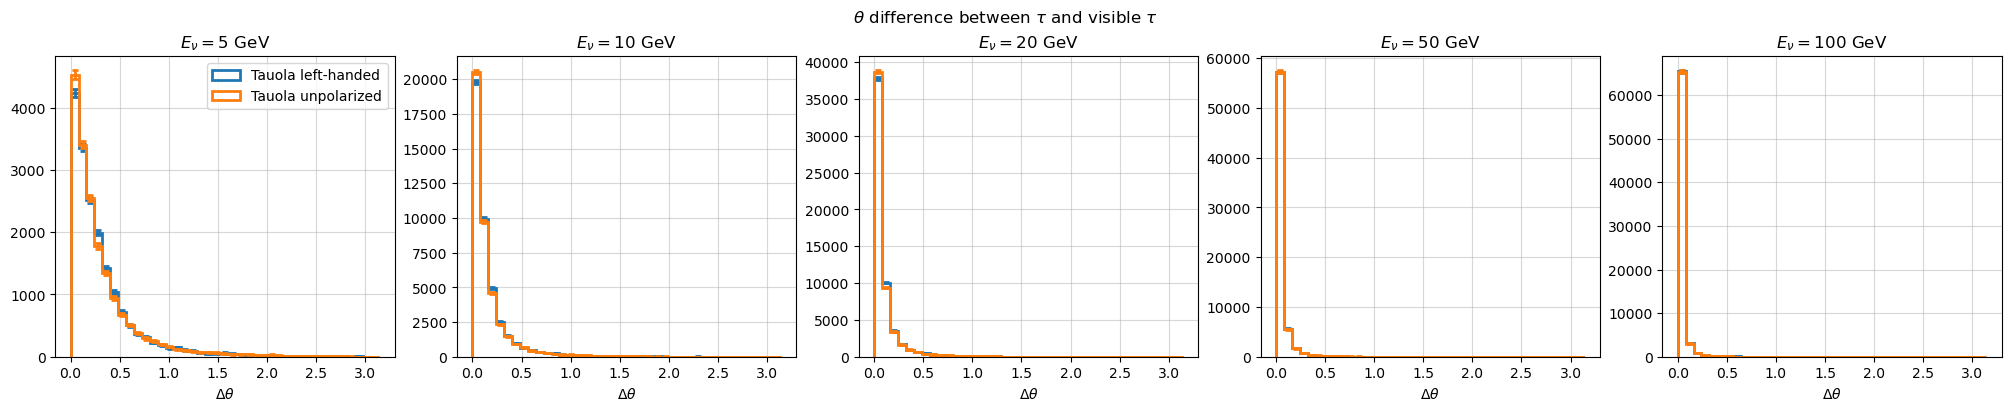

In [31]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 40) for e in nutau_energies}, filter_func=lambda values, index: True, plot_func=visible_delta_theta_tau, 
    xlabel=r"$\Delta\theta$", errorbar=True,
)
fig.suptitle(r"$\theta$ difference between $\tau$ and visible $\tau$")

## Investigate specific decay modes

In [14]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    return (values == -211).any() and (values == 16).any() and (values.size == 5)


def pion_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the pion relative to the total momentum of all decay products"""
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    return pion_momentum.values / tau_momentum.values


def nu_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products"""
    nu_momentum = (
        decay_products
        .groupby("event_num")
        .nth[3:]
        .query("pdg.abs() == 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)

    return nu_momentum.values / tau_momentum.values


def visible_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the visible decay products relative to the total decay products' momentum.
    The same as 1-nu_momentum_fraction, since visible_momentum_fraction + nu_momentum_fraction = 1"""
    only_decay_products = decay_products.groupby("event_num").nth[3:].copy()

    only_decay_products["P"] = (
        only_decay_products
        .query("pdg != 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    visible_momentum = only_decay_products.groupby("event_num")["P"].sum()

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    assert visible_momentum.shape == tau_momentum.shape

    return visible_momentum.values / tau_momentum.values
    #1 - nu_momentum_fraction(decay_products)

Text(0.5, 0.98, 'Pion momentum fraction for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

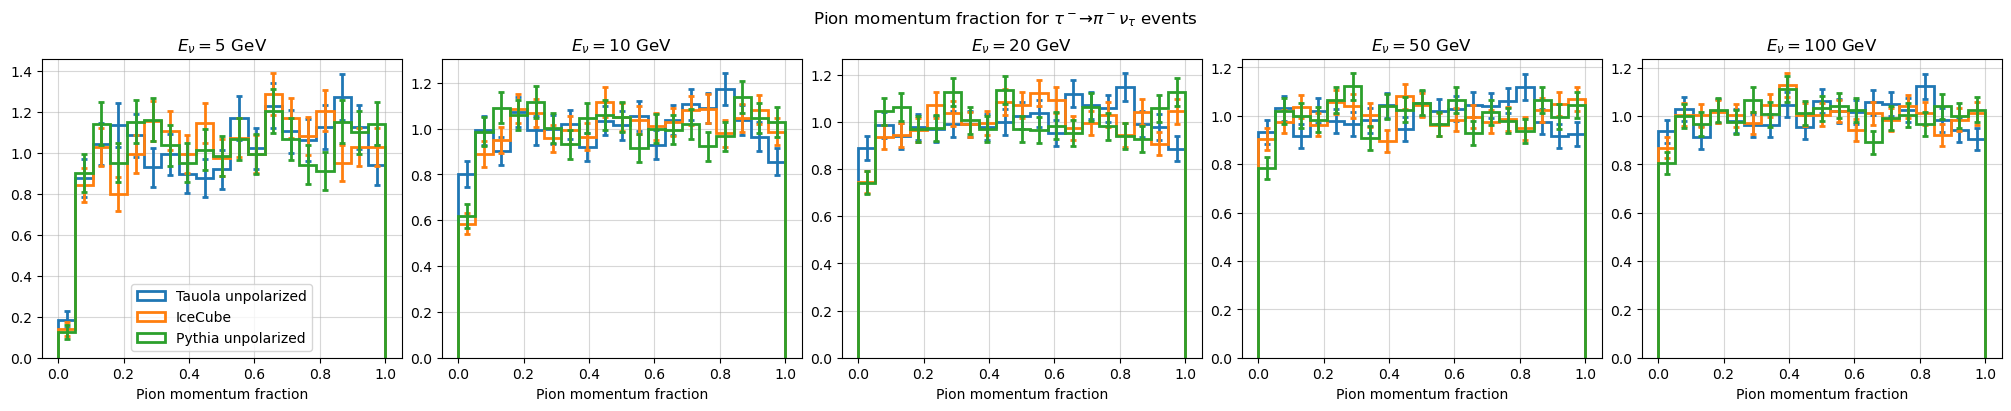

In [102]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=pion_momentum_fraction, 
    xlabel="Pion momentum fraction", density=True, errorbar=True,
)
fig.suptitle(r"Pion momentum fraction for $\tau^- \to \pi^- \nu_\tau$ events")

Text(0.5, 0.98, 'Pion momentum fraction for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

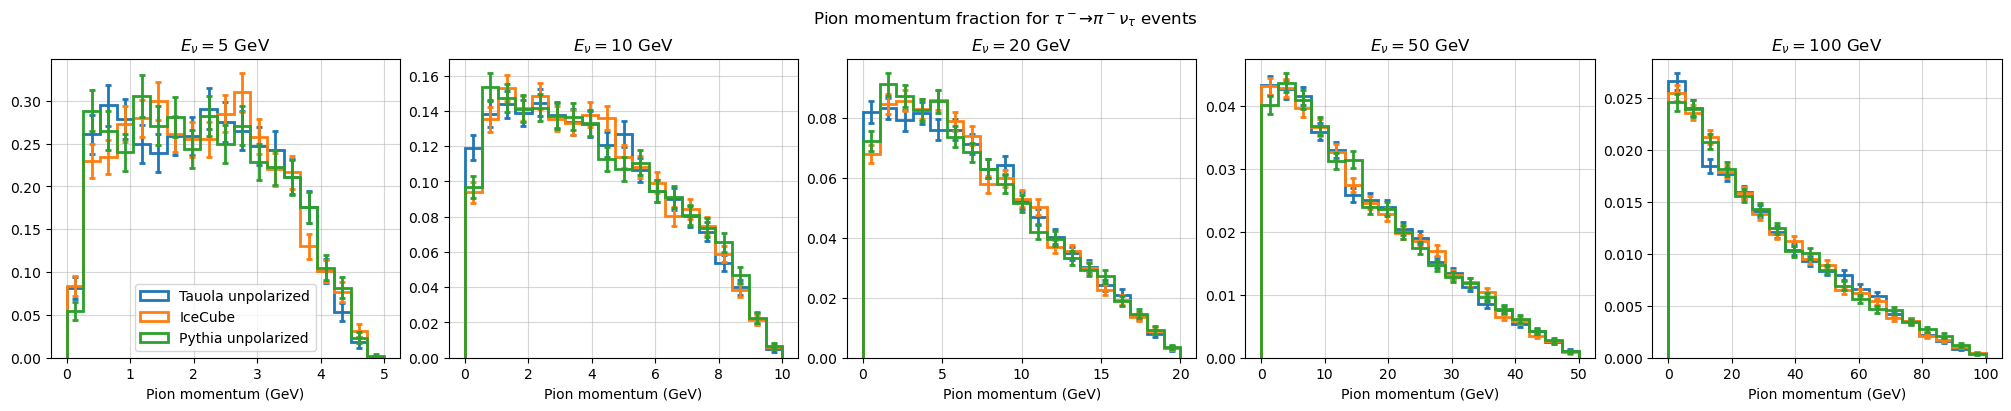

In [44]:
def pion_momentum(decay_products):
    pions = decay_products.query("pdg == -211")
    return np.sqrt(pions.px**2 + pions.py**2 + pions.pz**2)
    
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=pion_momentum, 
    xlabel="Pion momentum (GeV)", density=True, errorbar=True,
)

fig.suptitle(r"Pion momentum fraction for $\tau^- \to \pi^- \nu_\tau$ events")

Text(0.5, 0.98, 'Neutrino momentum for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

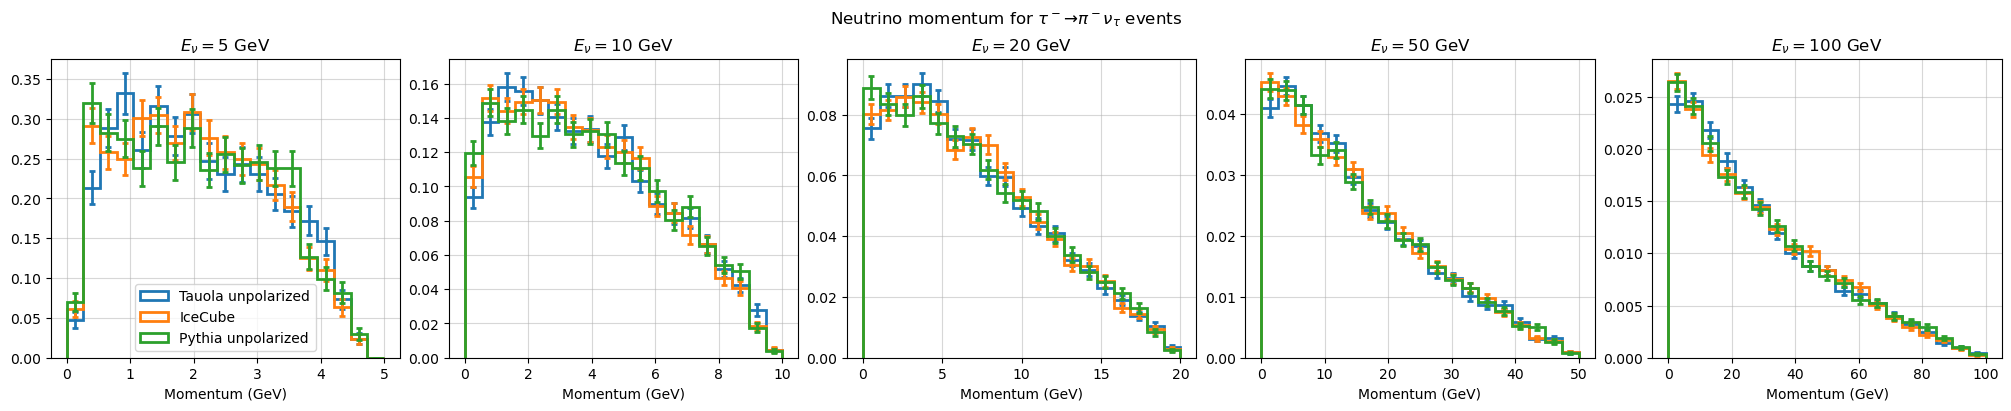

In [45]:
def nu_momentum(decay_products):
    nus = decay_products.groupby("event_num").nth[3:].query("pdg == 16")
    return np.sqrt(nus.px**2 + nus.py**2 + nus.pz**2)
    
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=nu_momentum, 
    xlabel="Momentum (GeV)", density=True, errorbar=True,
)

fig.suptitle(r"Neutrino momentum for $\tau^- \to \pi^- \nu_\tau$ events")

Text(0.5, 0.98, 'Pion $\\cos(\\theta)$ in lab frame for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

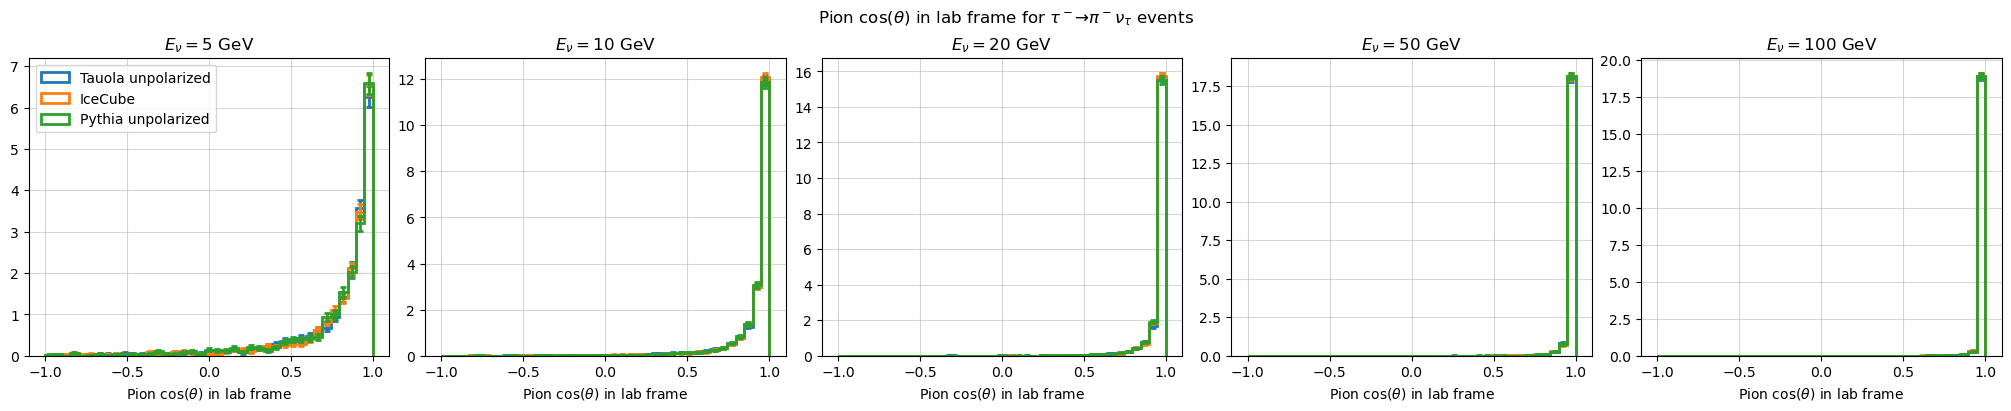

In [46]:
def pion_costheta(decay_products):
    pions = decay_products.query("pdg == -211")
    return (pions["pz"] / np.sqrt(pions.px**2 + pions.py**2 + pions.pz**2)).values

fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(-1, 1, 40) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=pion_costheta, 
    xlabel=r"Pion $\cos(\theta)$ in lab frame", density=True, errorbar=True,
)

fig.suptitle(r"Pion $\cos(\theta)$ in lab frame for $\tau^- \to \pi^- \nu_\tau$ events")

Text(0.5, 0.98, 'Pion momentum distribution for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

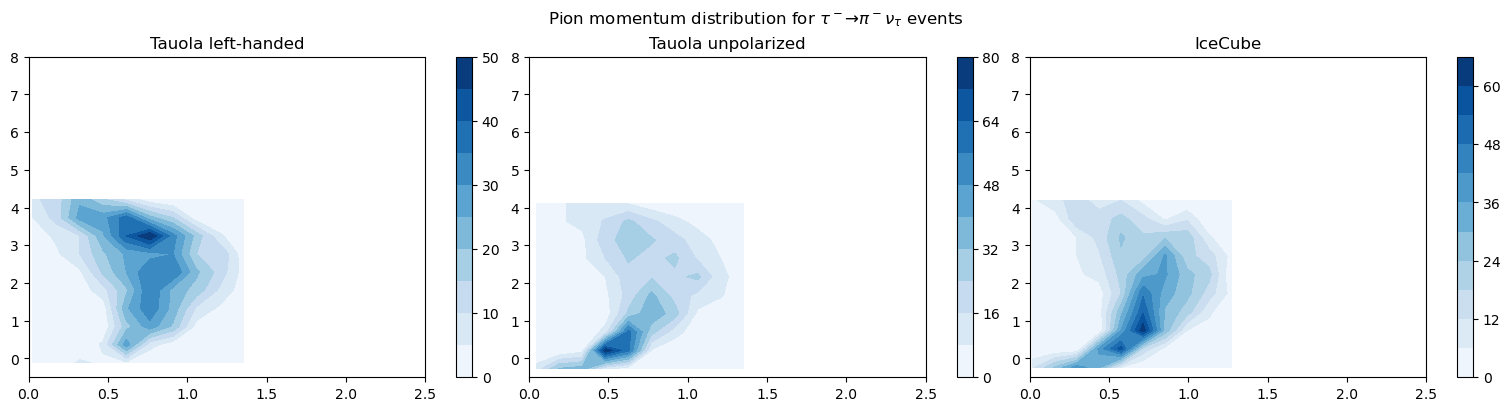

In [23]:
fig, axs = plt.subplots(ncols=len(datasets), figsize=(len(nutau_energies) * 3, 4), layout="constrained")
e = 5
event_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info.csv")

for (label, d), ax in zip(datasets.items(), axs):
    d_filtered = filter_events(d[e], "pdg", is_pion_nutau_event, engine="numba")
    pions = d_filtered.query("pdg == -211")
    events = event_info[event_info["event_num"].isin(pions["event_num"])]
    pions = pions[events["qel"].values]
    # Make a 2D histogram as a contour plot of the pion transverse momentum vs pion z momentum
    values, xedges, yedges = np.histogram2d(np.sqrt(pions.px**2 + pions.py**2), pions.pz, bins=10)
    im = ax.contourf(xedges[:-1], yedges[:-1], values.T, levels=10, cmap="Blues")
    fig.colorbar(im, ax=ax)
    ax.set(title=label, xlim=(0, 2.5), ylim=(-0.5, 8))

fig.suptitle(r"Pion momentum distribution for $\tau^- \to \pi^- \nu_\tau$ events")

In [47]:
# Plot the muon angle relative to the tau direction in the tau rest frame
def pion_angle(decay_products):
    pion = decay_products.query("pdg == -211")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    pion_vec = vector.array({"E": pion["E"], "px": pion["px"], "py": pion["py"], "pz": pion["pz"]})

    pion_vec_boosted = pion_vec.boostCM_of(tau_vec)
    
    return (pion_vec_boosted.pz / pion_vec_boosted.p)

Text(0.5, 0.98, '$\\pi^-$ $\\cos(\\theta)$ helicity angle in $\\tau$ frame for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

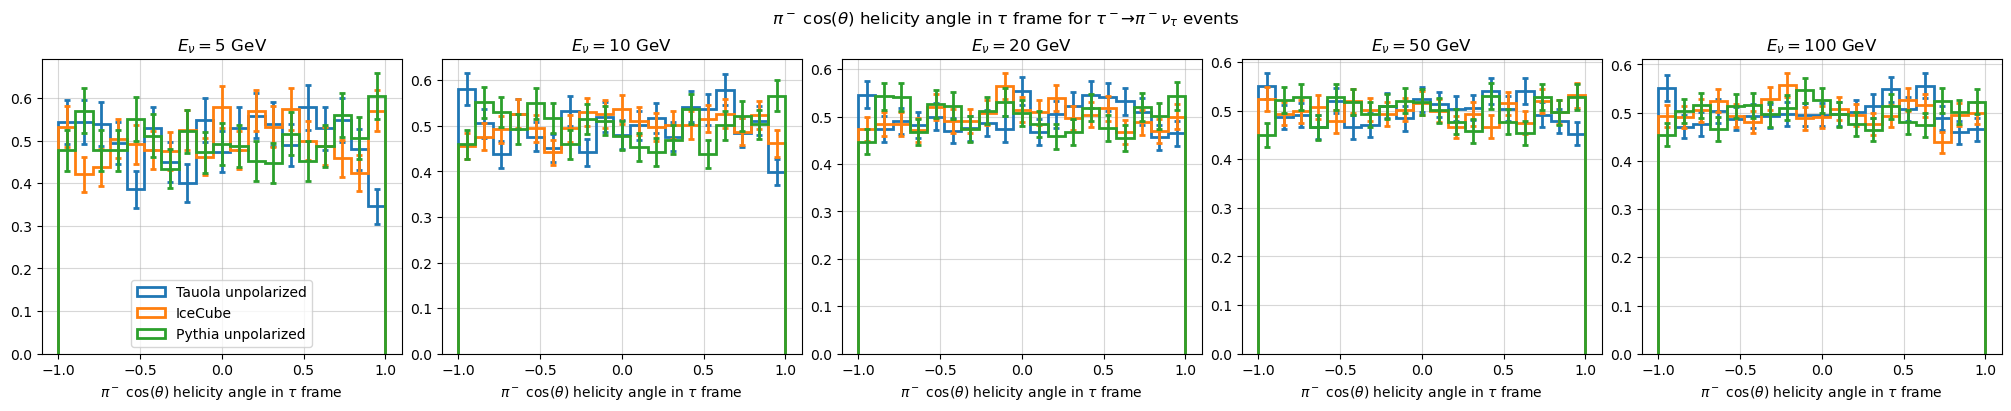

In [48]:
fig, ax = plot_histograms(
    datasets,
    bins={e: np.linspace(-1, 1, 20) for e in nutau_energies}, 
    filter_func=is_pion_nutau_event, plot_func=pion_angle, 
    xlabel=r"$\pi^-$ $\cos(\theta)$ helicity angle in $\tau$ frame", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"$\pi^-$ $\cos(\theta)$ helicity angle in $\tau$ frame for $\tau^- \to \pi^- \nu_\tau$ events")


Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

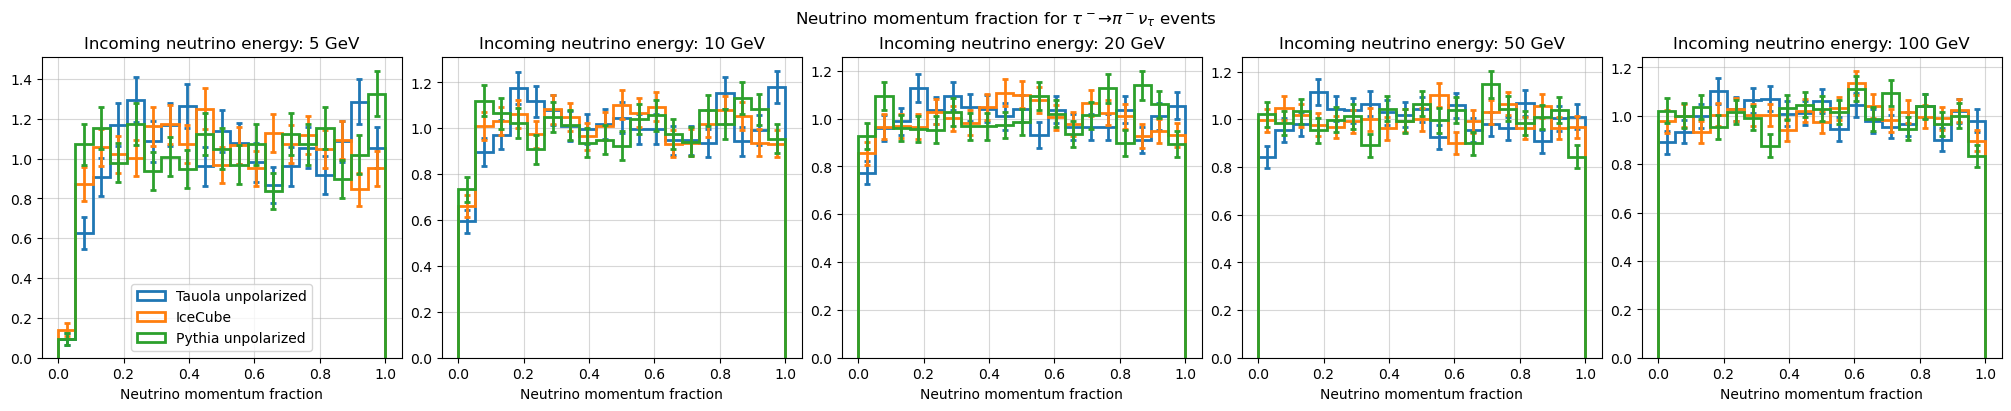

In [49]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_pion_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \pi^- \nu_\tau$ events")

We see a clear difference between the decay using Tauola with real polarization given by GENIE and the unpolarized decay by Geant4.
A similar difference would likely be seen for the IceCube simulations.

In [50]:
@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    """Check if a given event contains a pi0, a pi- and a tau neutrino"""
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 1) and (values == 16).any() and (values.size == 6)

Text(0.5, 0.98, 'Visible momentum fraction for $\\tau^- \\to \\pi^0 \\pi^- \\nu_\\tau$ events')

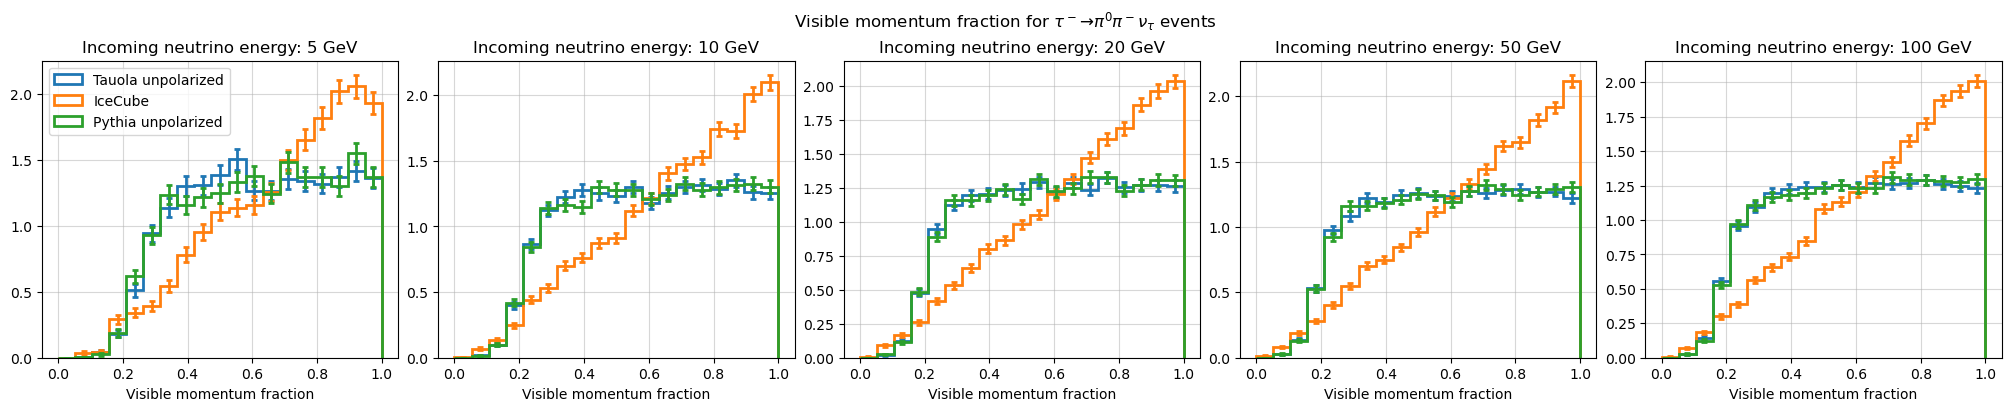

In [51]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_pi0_pim_nutau_event, plot_func=visible_momentum_fraction, 
    xlabel="Visible momentum fraction", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"Visible momentum fraction for $\tau^- \to \pi^0 \pi^- \nu_\tau$ events")

In [52]:
@numba.njit
def is_2pim_pip_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 2) and ((values == 211).sum() == 1) and (values == 16).any() and (values.size == 7)

Text(0.5, 0.98, 'Visible momentum fraction for $\\tau^- \\to \\pi^- \\pi^- \\pi^+ \\nu_\\tau$ events')

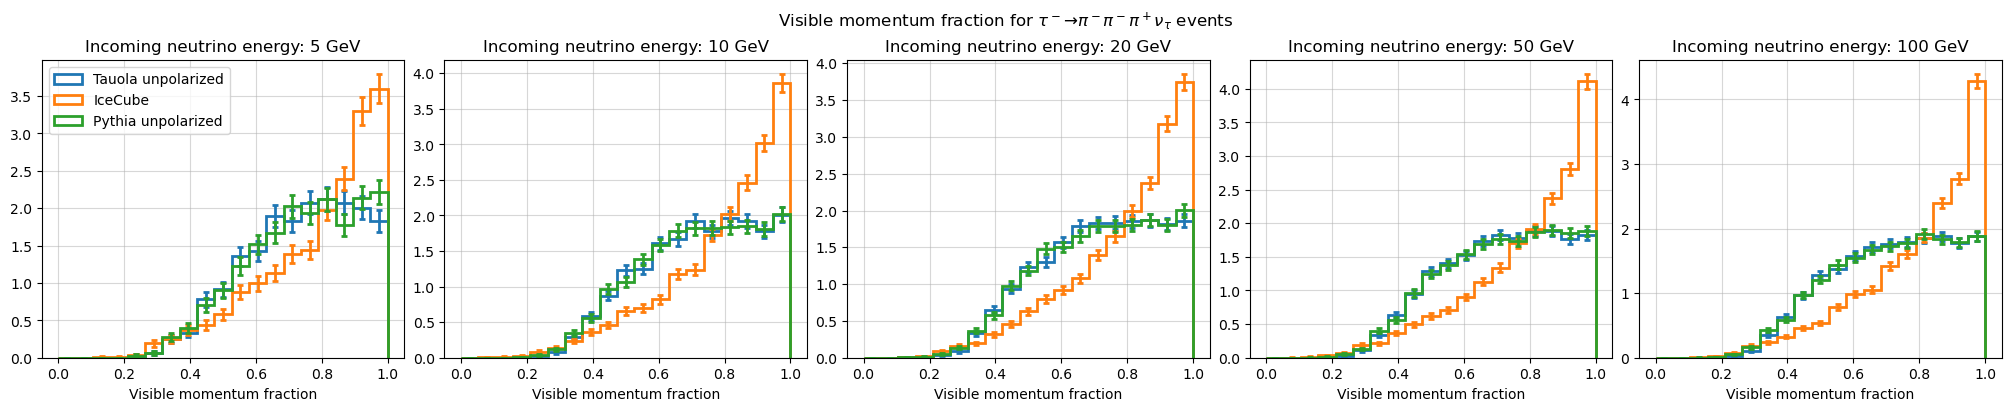

In [53]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_2pim_pip_nutau_event, plot_func=visible_momentum_fraction, 
    xlabel="Visible momentum fraction", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"Visible momentum fraction for $\tau^- \to \pi^- \pi^- \pi^+ \nu_\tau$ events")

In [54]:
@numba.njit
def is_2pi0_pim_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 2) and (values == 16).any() and (values.size == 7)

Text(0.5, 0.98, 'Visible momentum fraction for $\\tau^- \\to \\pi^0 \\pi^0 \\pi^- \\nu_\\tau$ events')

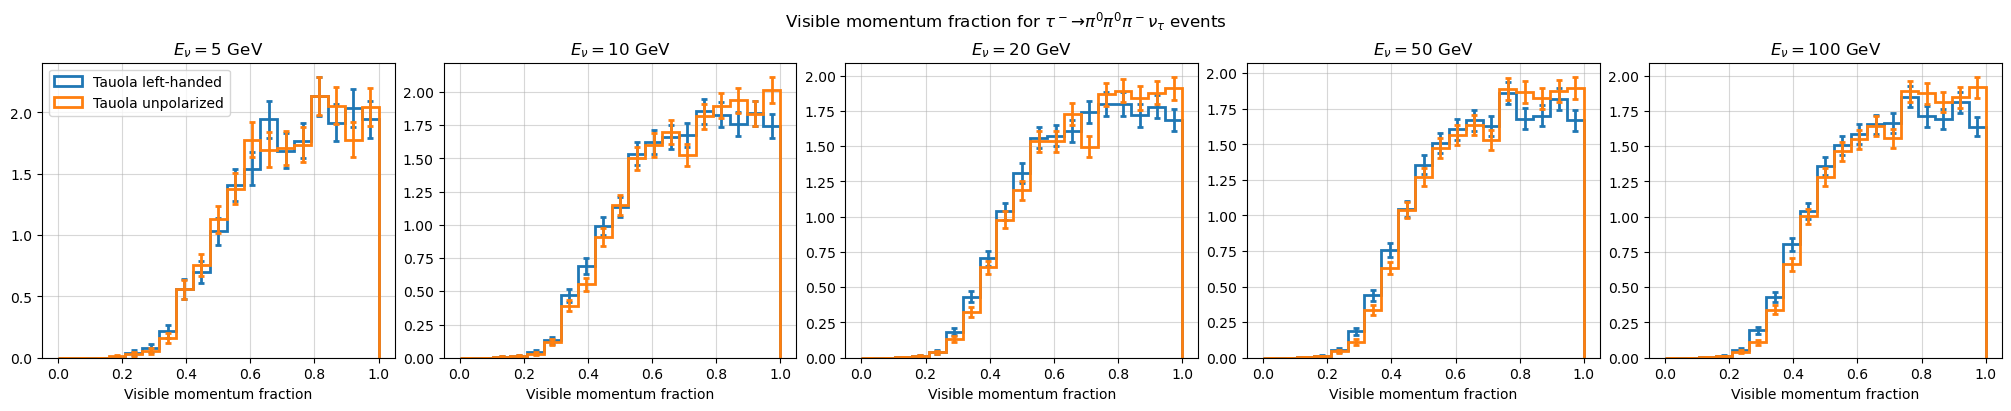

In [169]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_2pi0_pim_nutau_event, plot_func=visible_momentum_fraction, 
    xlabel="Visible momentum fraction", density=True, errorbar=True,
)

fig.suptitle(r"Visible momentum fraction for $\tau^- \to \pi^0 \pi^0 \pi^- \nu_\tau$ events")

Looks kind of similar to fig 6 in Dune paper but not exactly the same.

Based on this plot and comparing it to the PROPOSAL presentation, it seems like the boosted simulations are the most accurate. Though I do not know how comparable these two plots are.

In [56]:
@numba.njit
def is_e_nue_nutau_event(values, index) -> bool:
    return ((values == 11).sum() == 1) and ((values == -12).sum() == 1) and (values == 16).any() and (values.size == 6)

Text(0.5, 0.98, 'Visible momentum fraction for $\\tau^- \\to \\bar\\nu_e e^- \\nu_\\tau$ events')

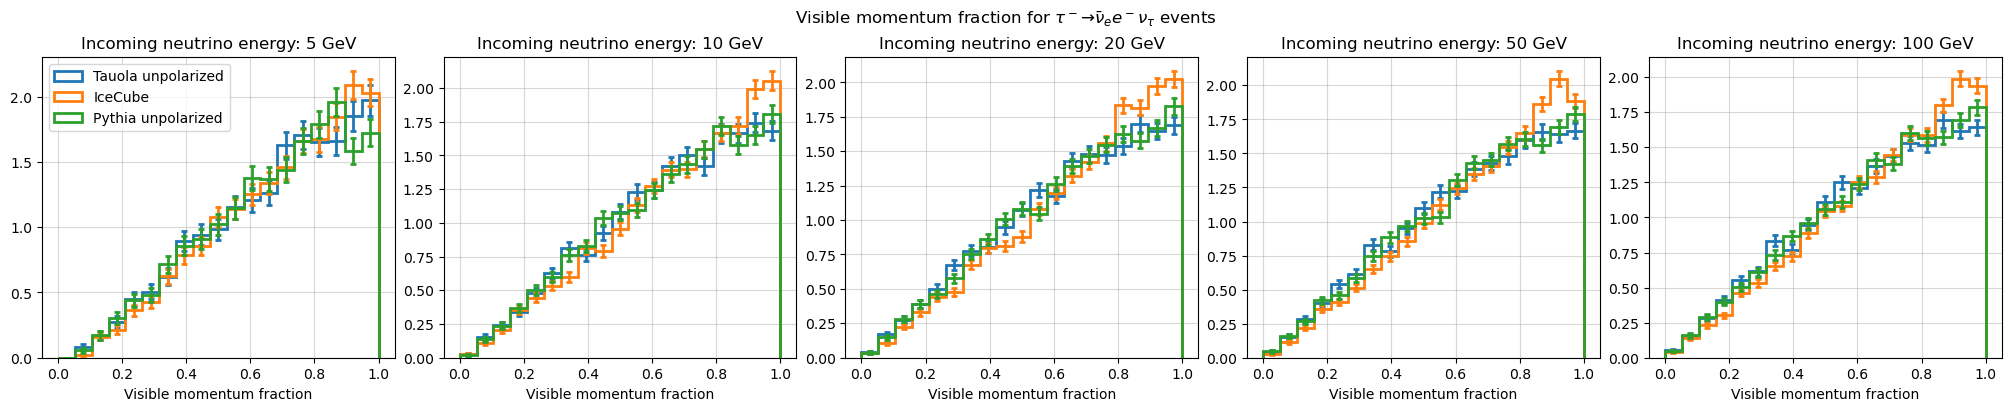

In [57]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_e_nue_nutau_event, plot_func=visible_momentum_fraction, 
    xlabel="Visible momentum fraction", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"Visible momentum fraction for $\tau^- \to \bar\nu_e e^- \nu_\tau$ events")

In [58]:
def e_pol_angle(decay_products):
    # Plot the electron angle relative to the tau direction in the tau rest frame
    e = decay_products.query("pdg == 11")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    e_vec = vector.array({"E": e["E"], "px": e["px"], "py": e["py"], "pz": e["pz"]})

    e_vec_boosted = e_vec.boostCM_of(tau_vec)
    
    return e_vec_boosted.deltaangle(vector.array({"x": tau.polx.values, "y": tau.poly.values, "z": tau.polz.values}))
    #np.arccos(e_vec_boosted.px * tau.polx.values + muon_vec_boosted.py * tau.poly.values + muon_vec_boosted.pz * tau.polz.values) / muon_vec_boosted.p)

AttributeError: 'DataFrame' object has no attribute 'polx'

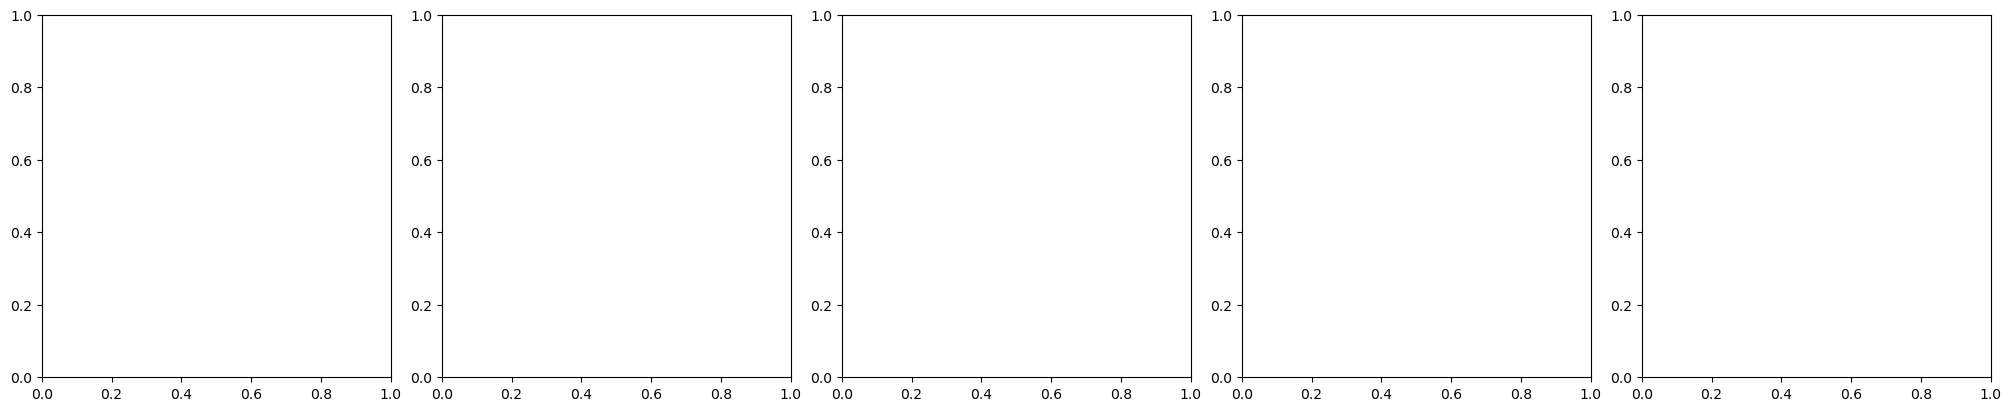

In [88]:
fig, ax = plot_histograms(
    datasets,
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, 
    filter_func=is_e_nue_nutau_event, plot_func=e_pol_angle, 
    xlabel=r"$e$ angle relative to the $\tau$ polarization angle", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"$e$ angle relative to the $\tau$ polarization angle in $\tau$ frame for $\tau^- \to \bar\nu_e e^- \nu_\tau$ events")


The opposite distribution to the Dune paper, but at least the same as Geant4

## Track-like events
These are mainly caused by muons

In [99]:
@numba.njit
def is_mu_numu_nutau_event(values, index) -> bool:
    return ((values == 13).sum() == 1) and ((values == -14).sum() == 1) and (values == 16).any() and (values.size == 6)

def mu_e_fraction(decay_products):
    mu = decay_products.query("pdg == 13")["E"].values
    tau = decay_products.query("pdg == 15")["E"].values
    assert mu.shape == tau.shape
    # print(mu)
    return mu / tau


# Plot the muon angle relative to the tau direction in the tau rest frame
def muon_angle(decay_products):
    muon = decay_products.query("pdg == 13")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    muon_vec = vector.array({"E": muon["E"], "px": muon["px"], "py": muon["py"], "pz": muon["pz"]})
    
    muon_vec_boosted = muon_vec.boostCM_of(tau_vec)
    
    return (muon_vec_boosted.pz / muon_vec_boosted.p)

def muon_pol_angle(decay_products, emax_fraction=0):
    # Plot the muon angle relative to the tau direction in the tau rest frame
    muon = decay_products.query("pdg == 13")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    muon_vec = vector.array({"E": muon["E"], "px": muon["px"], "py": muon["py"], "pz": muon["pz"]})
    
    muon_vec_boosted = muon_vec.boostCM_of(tau_vec)
    selected_muons = muon_vec_boosted.E > 1.77682/2 * emax_fraction
    delta_angles = np.zeros(selected_muons.shape)
    # Setting all non-high energy muons to nan. Note: this makes the error bars incorrect
    delta_angles[~selected_muons] = np.nan
    delta_angles[selected_muons] = muon_vec_boosted[selected_muons].deltaangle(
        vector.array({"x": tau.polx.values[selected_muons], "y": tau.poly.values[selected_muons], "z": tau.polz.values[selected_muons]}
        )
    )

    return delta_angles
    #muon_vec_boosted.deltaangle(vector.array({"x": tau.polx.values, "y": tau.poly.values, "z": tau.polz.values}))
    #np.arccos(muon_vec_boosted.px * tau.polx.values + muon_vec_boosted.py * tau.poly.values + muon_vec_boosted.pz * tau.polz.values) / muon_vec_boosted.p)



Text(0.5, 0.98, 'Visible momentum fraction for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

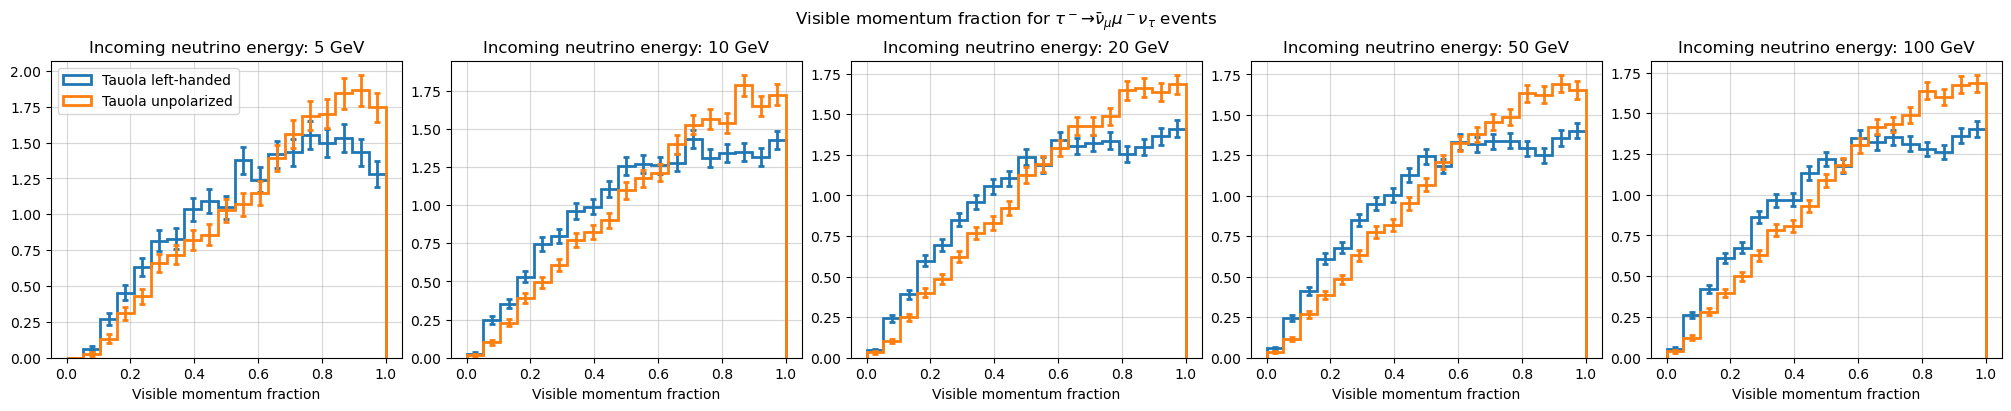

In [16]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=visible_momentum_fraction, 
    xlabel="Visible momentum fraction", density=True, errorbar=True,
)
fig.suptitle(r"Visible momentum fraction for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, '$E_\\mu / E_\\tau$ for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

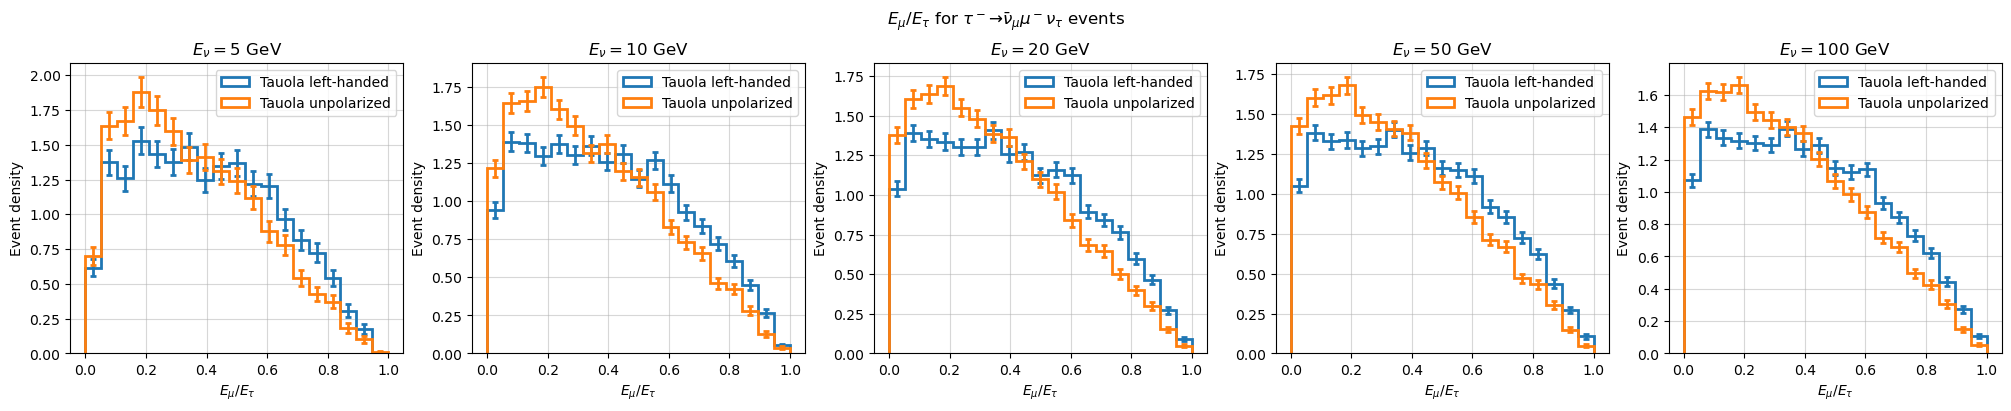

In [100]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_\mu / E_\tau$", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"$E_\mu / E_\tau$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, '$E_\\mu$ for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

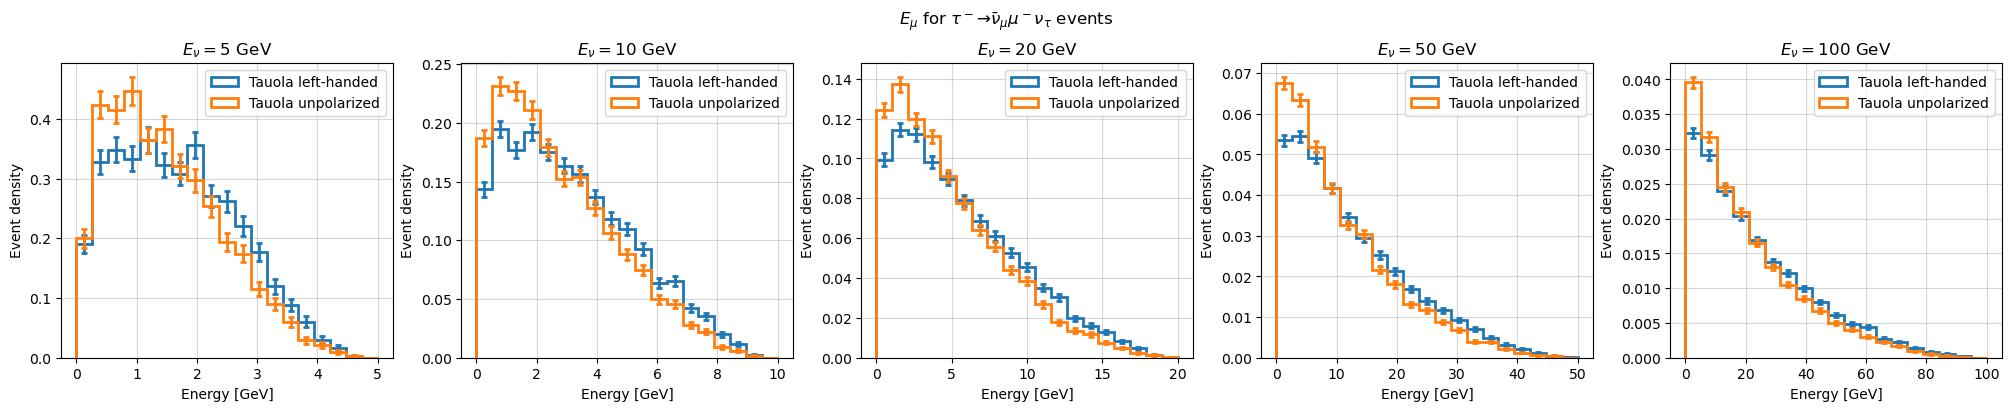

In [101]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=tau_visible_e, 
    xlabel=r"Energy [GeV]",  errorbar=True, density=True, ylabel="Event density",
)
fig.suptitle(r"$E_\mu$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, 'Outgoing neutrino energy for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

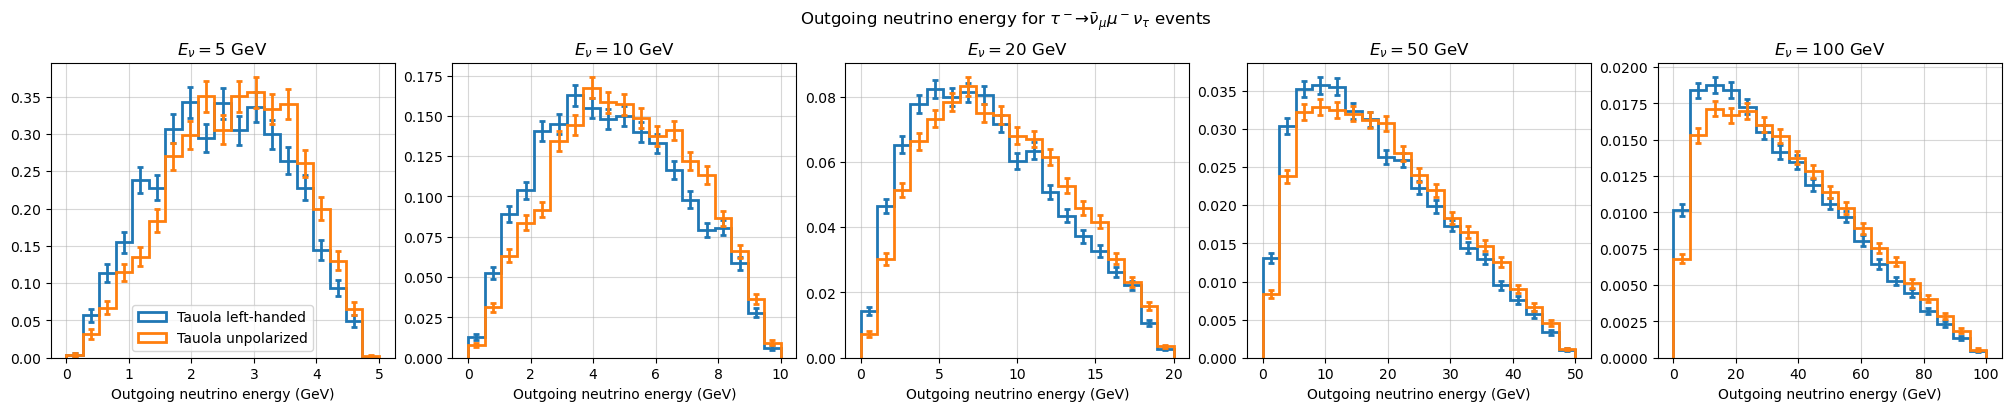

In [38]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=missing_energy,
    xlabel="Outgoing neutrino energy (GeV)", errorbar=True, density=True,
)
fig.suptitle(r"Outgoing neutrino energy for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, 'Muon angle relative to incoming neutrino for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

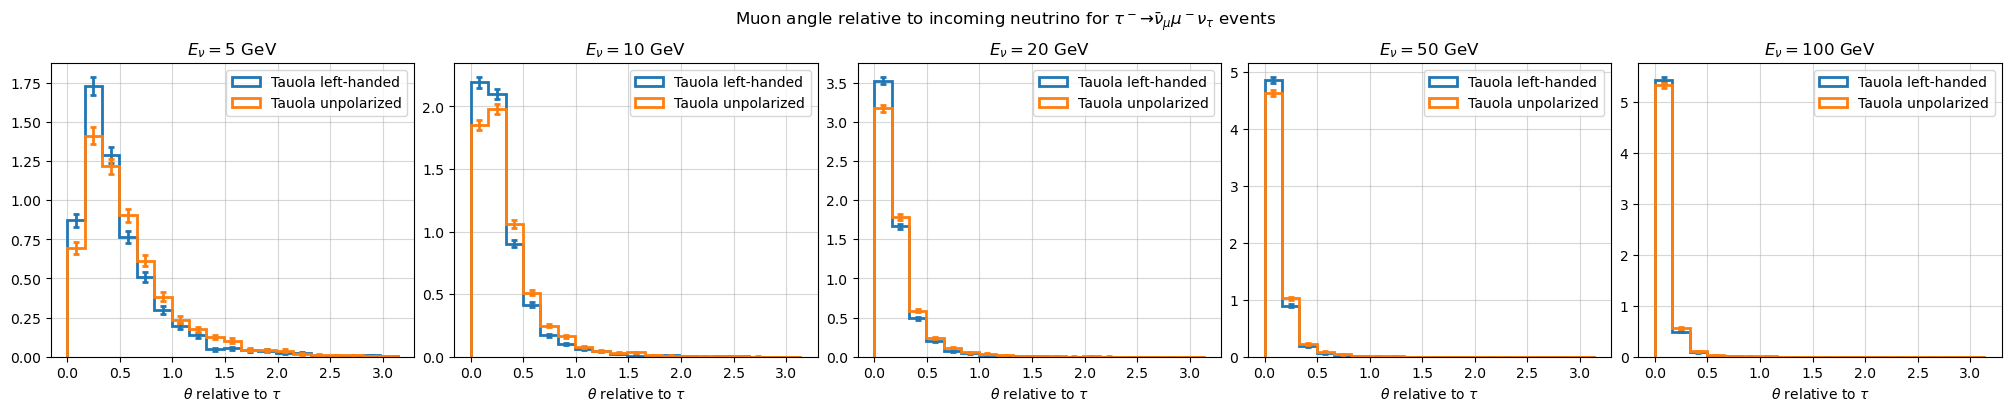

In [103]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=visible_theta, 
    xlabel=r"$\theta$ relative to $\tau$", errorbar=True, density=True,
)
fig.suptitle(r"Muon angle relative to incoming neutrino for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, 'Muon angle relative to $\\tau$ for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

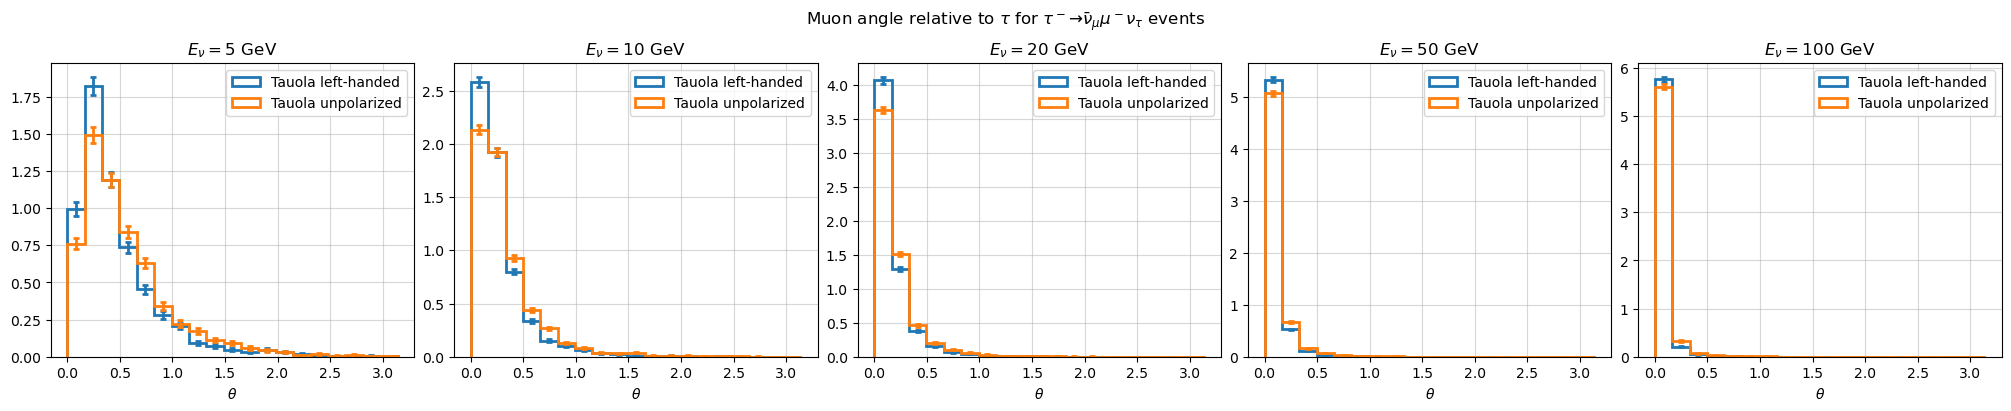

In [106]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=visible_theta_tau, 
    xlabel=r"$\theta$", errorbar=True, density=True,
)
fig.suptitle(r"Muon angle relative to $\tau$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

Text(0.5, 0.98, '$\\theta_\\tau - \\theta_\\mu$ for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

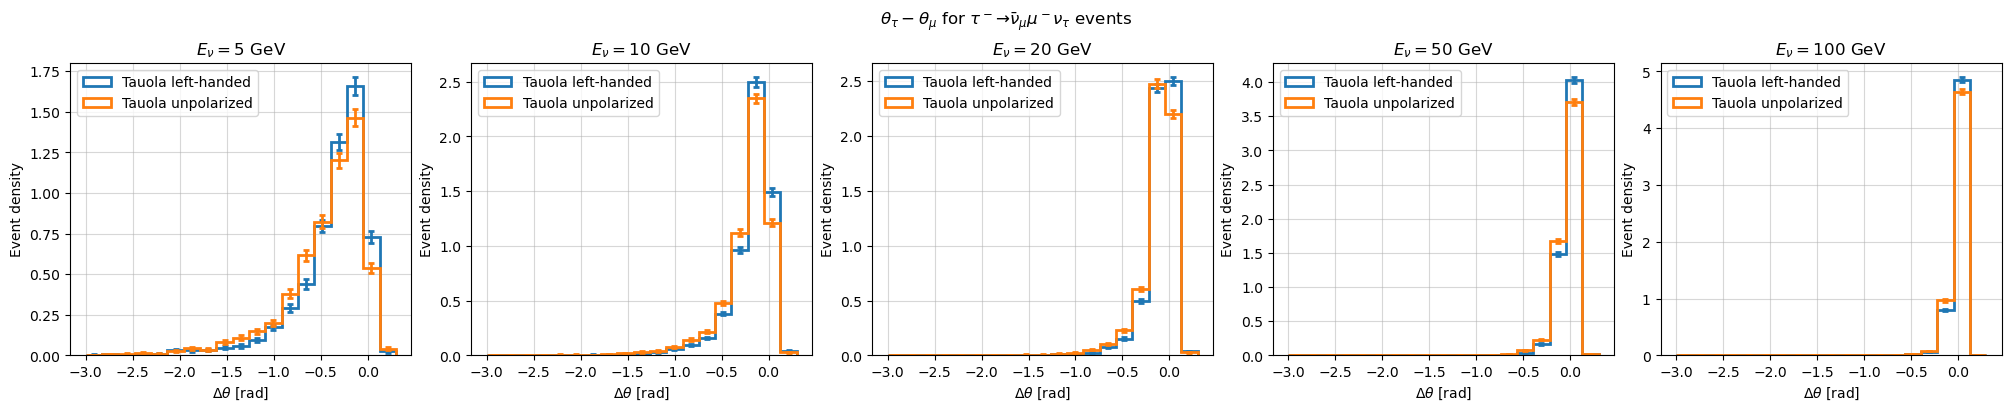

In [84]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(-3, 0.3, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=visible_delta_theta_tau, 
    xlabel=r"$\Delta\theta$ [rad]", errorbar=True, density=True, ylabel="Event density",
)
fig.suptitle(r"$\theta_\tau - \theta_\mu$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

According to the theory of polarized decays, the muon should move in the same direction as the tau polarization when it has roughly half of the tau mass as its energy.

This is because when it has this much energy, the other half is carried by the two neutrinos that move in the opposite direction. These two neutrinos will be neutrino, and anti-neutrinos and therefore cancel each other's helicities out. This means that the muon will have the same helicity as the tau.

AttributeError: 'DataFrame' object has no attribute 'polx'

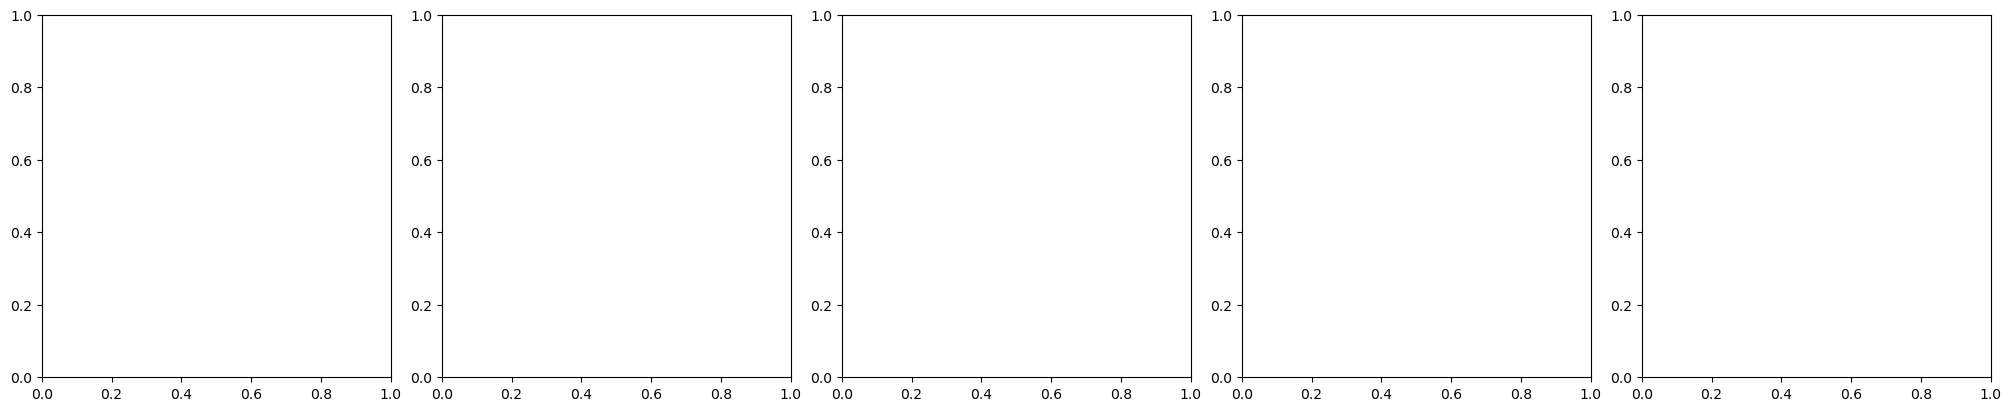

In [68]:
fig, ax = plot_histograms(
    datasets,
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=lambda df: muon_pol_angle(df, 0.99), 
    xlabel=r"$\mu$ angle relative to the $\tau$ polarization angle", density=True, errorbar=True,
)
for ax, e in zip(axs, nutau_energies):
    ax.set_title(f"Incoming neutrino energy: {e} GeV")
fig.suptitle(r"$\mu$ angle relative to the $\tau$ polarization angle in $\tau$ frame for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")


## Cascade-like events
These are all events that are not muon events

Text(0.5, 0.98, '$E_{vis} / E_\\tau$ for cascade-like events')

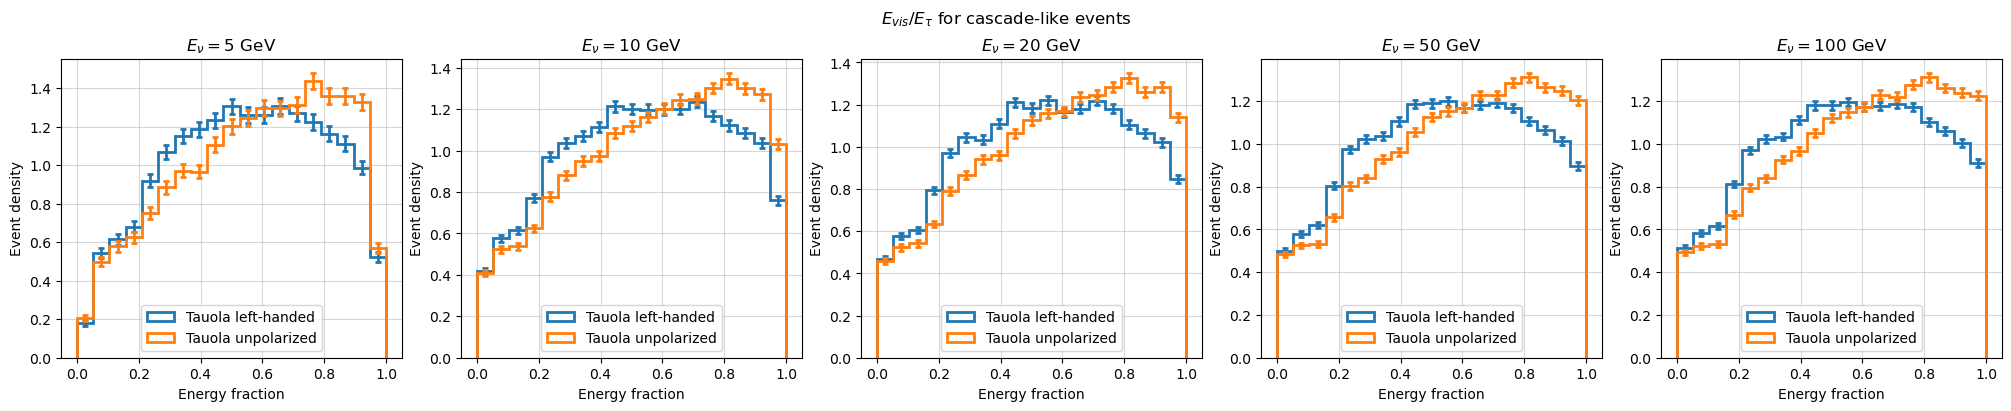

In [86]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not is_mu_numu_nutau_event(values, index)), plot_func=tau_visible_e_fraction, 
    xlabel=r"Energy fraction", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"$E_{vis} / E_\tau$ for cascade-like events")

Text(0.5, 0.98, '$E_{vis}$ for cascade-like events')

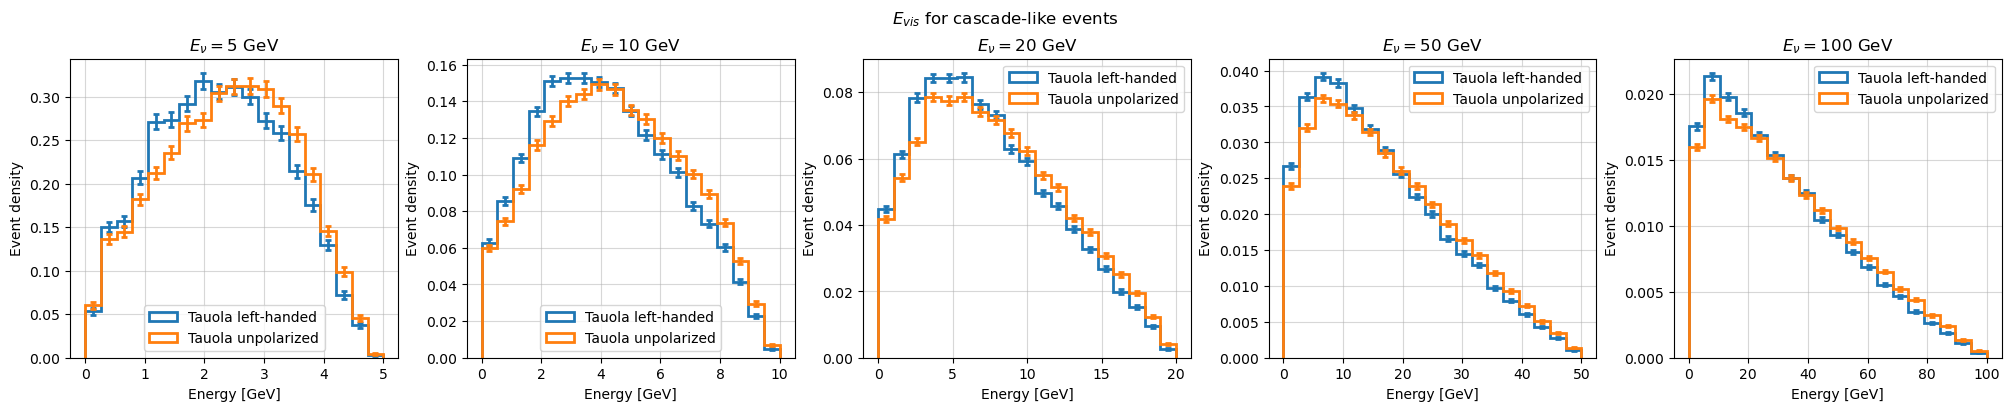

In [85]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not is_mu_numu_nutau_event(values, index)), plot_func=tau_visible_e, 
    xlabel=r"Energy [GeV]", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"$E_{vis}$ for cascade-like events")

Text(0.5, 0.98, 'Angle between $\\tau$ and visible $\\tau$ for cascade-like events')

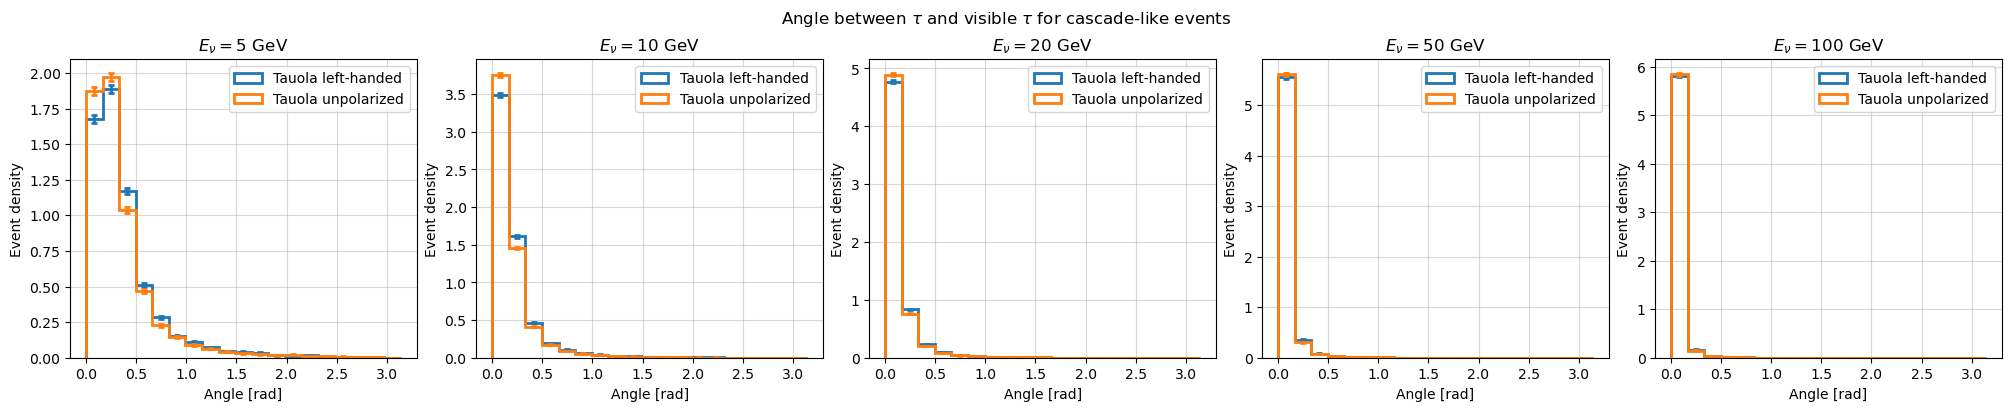

In [88]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not is_mu_numu_nutau_event(values, index)), plot_func=visible_theta_tau, 
    xlabel=r"Angle [rad]", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"Angle between $\tau$ and visible $\tau$ for cascade-like events")

Text(0.5, 0.98, 'Angle between incoming neutrino and visible $\\tau$ for cascade-like events')

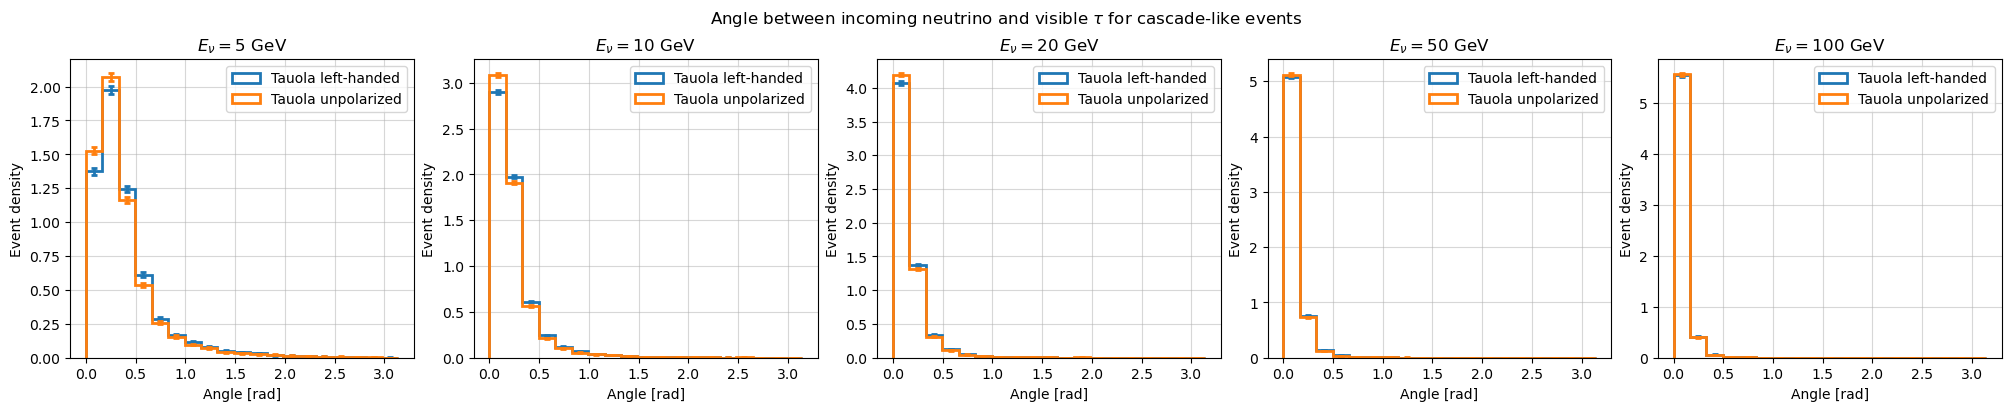

In [89]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, np.pi, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not is_mu_numu_nutau_event(values, index)), plot_func=visible_theta, 
    xlabel=r"Angle [rad]", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"Angle between incoming neutrino and visible $\tau$ for cascade-like events")

Text(0.5, 0.98, '$\\theta_\\tau - \\theta_{vis}$ for cascade-like events')

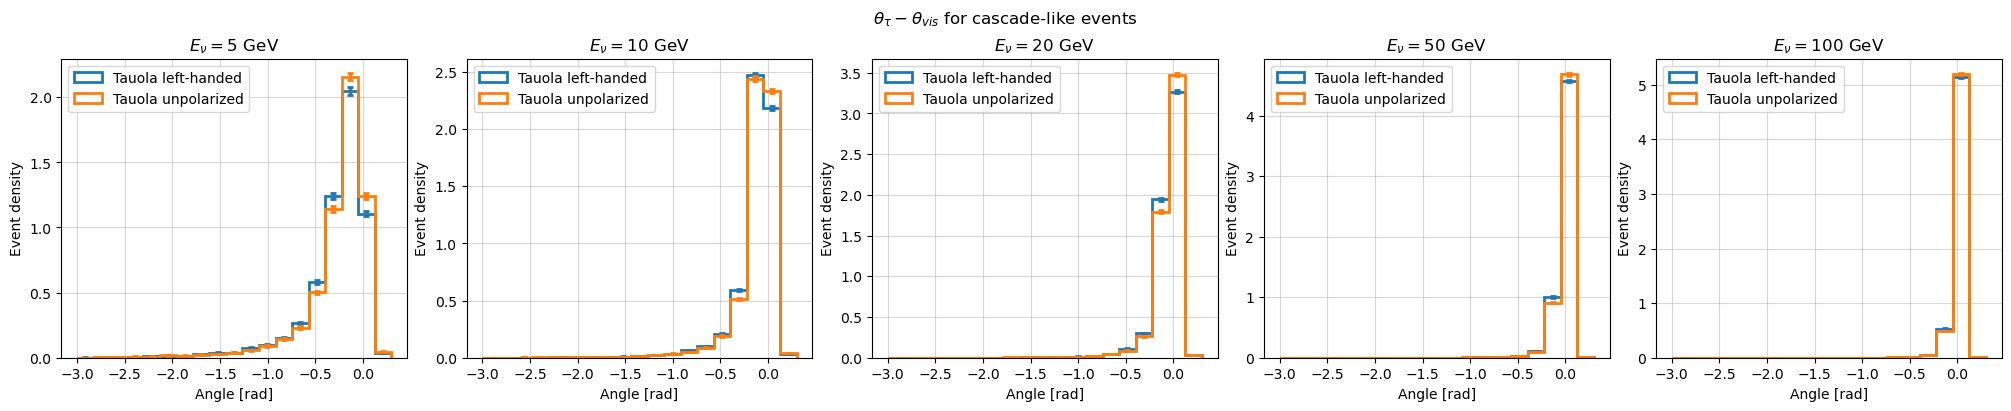

In [87]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(-3, 0.3, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not is_mu_numu_nutau_event(values, index)), plot_func=visible_delta_theta_tau, 
    xlabel=r"Angle [rad]", density=True, errorbar=True, ylabel="Event density",
)
fig.suptitle(r"$\theta_\tau - \theta_{vis}$ for cascade-like events")

## Sanity checks

In [89]:
# Check that all events from IceCube are covered by the filter functions above, i.e. I have plotted all possible decay modes in Geant4
for e in nutau_energies:
    mask = np.stack([
        decay_products_ic[e].groupby("event_num")["pdg"].agg(filter_func, engine="numba") 
        for filter_func in 
        (is_pion_nutau_event, is_pi0_pim_nutau_event, is_2pim_pip_nutau_event, is_2pi0_pim_nutau_event, is_mu_numu_nutau_event, is_e_nue_nutau_event)
    ])
    assert (np.sum(mask, axis=0) == 1).all(), f"{e}: {np.where(np.sum(mask, axis=0) != 1)[0]}"

# Check that when selecting events, only one decay mode is selected
for simulation in datasets.values():
    for func in (is_pion_nutau_event, is_pi0_pim_nutau_event, is_2pim_pip_nutau_event, is_2pi0_pim_nutau_event, is_mu_numu_nutau_event, is_e_nue_nutau_event):
        for e, df in simulation.items():
            mask = df.groupby("event_num")["pdg"].agg(func, engine="numba")
            selected_event_idx = mask[mask > 0].index
            print(f"Energy: {e} GeV")
            print(len(selected_event_idx))
            selected_events = df.loc[df["event_num"].isin(selected_event_idx)].groupby("event_num").nth[3:]
            c = Counter(tuple(sorted(a.tolist())) for i, a in selected_events.groupby("event_num")["pdg"])
            assert len(c) == 1, c

Energy: 5 GeV
1923
Energy: 10 GeV
4625
Energy: 20 GeV
6156
Energy: 50 GeV
7299
Energy: 100 GeV
7775
Energy: 5 GeV
4530
Energy: 10 GeV
10783
Energy: 20 GeV
14226
Energy: 50 GeV
16752
Energy: 100 GeV
17682
Energy: 5 GeV
1632
Energy: 10 GeV
3757
Energy: 20 GeV
4989
Energy: 50 GeV
5818
Energy: 100 GeV
6142
Energy: 5 GeV
1652
Energy: 10 GeV
3940
Energy: 20 GeV
5159
Energy: 50 GeV
6091
Energy: 100 GeV
6423
Energy: 5 GeV
3120
Energy: 10 GeV
7236
Energy: 20 GeV
9601
Energy: 50 GeV
11288
Energy: 100 GeV
11920
Energy: 5 GeV
2730
Energy: 10 GeV
6576
Energy: 20 GeV
8687
Energy: 50 GeV
10239
Energy: 100 GeV
10795
Energy: 5 GeV
2282
Energy: 10 GeV
5228
Energy: 20 GeV
6954
Energy: 50 GeV
8192
Energy: 100 GeV
8642
Energy: 5 GeV
5042
Energy: 10 GeV
12075
Energy: 20 GeV
15702
Energy: 50 GeV
18812
Energy: 100 GeV
19860
Energy: 5 GeV
1854
Energy: 10 GeV
4472
Energy: 20 GeV
5927
Energy: 50 GeV
6853
Energy: 100 GeV
7382
Energy: 5 GeV
1775
Energy: 10 GeV
4333
Energy: 20 GeV
5776
Energy: 50 GeV
6704
Energy: 1

In [85]:
decay_products_ic[100].query("event_num == 26993")

,event_num,pdg,E,px,py,pz,polx,poly,polz
164224,26993,1000080160,14.895082,0.000000,0.000000,0.000000,NaN,NaN,NaN
164225,26993,16,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
164226,26993,15,73.950780,-3.333953,2.191839,73.821686,0.029648,0.045096,-0.998543
164227,26993,11,1.311256,-0.050931,0.022902,1.310066,NaN,NaN,NaN
164228,26993,11,10.496834,-0.630861,0.522362,10.464830,NaN,NaN,NaN
164229,26993,-12,35.058680,-2.194256,0.682401,34.983290,NaN,NaN,NaN
164230,26993,16,27.084062,-0.458585,0.964477,27.062998,NaN,NaN,NaN


In [49]:
from utils import branching_ratios

In [52]:
for e in nutau_energies:
    print(branching_ratios(decay_products_pythia[e].groupby("event_num").nth[3:]))

{(-211, 16, 111): 0.25345338627593533, (-12, 11, 16): 0.17459873608858564, (-14, 13, 16): 0.17208209831664895, (-211, 16): 0.1089983781667692, (-211, 16, 111, 111): 0.09803702253788937, (-211, -211, 16, 211): 0.09602371232034003, (-211, -211, 16, 111, 211): 0.04535540517868128, (-211, 16, 111, 111, 111): 0.011240982047983893, (-321, 16): 0.006319557071752139, (-211, -211, 16, 111, 111, 211): 0.005089200827694201, (-321, -211, 16, 211): 0.004921424976231754, (-321, 16, 111): 0.0038029192998154464, (-211, 16, 130): 0.003579218164532185, (-211, 16, 111, 130): 0.002572563055757508, (-211, 16, 22, 111): 0.001845534366086908, (-211, 16, 111, 111, 111, 111): 0.001565907946982831, (-321, -211, 16, 321): 0.0014540573793412, (-211, -211, -211, 16, 211, 211): 0.0009507298249538616, (-321, 16, 111, 111): 0.0009507298249538616, (-211, -211, 16, 130, 211): 0.0008948045411330463, (-321, 16, 111, 111, 111): 0.0008388792573122308, (-321, -211, 16, 111, 211): 0.0008388792573122308, (-321, 16, 130): 0.00

In [59]:
for e in nutau_energies[-1:]:
    print(f"Energy: {e} GeV")
    # Convert the print statements above to a table. One table for each energy. Each row is a decay mode and each column is the branching ratios for the different simulations.
    table = {}
    for name, df in datasets.items():
        table[name] = {str(key): value for key, value in branching_ratios(df[e].groupby("event_num").nth[3:]).items()}
    
    df = pd.DataFrame(table)
    # Replace NaN with 0
    # df = df.fillna(0)
    display(df[df.drop("IceCube", axis=1).isnull().any(axis=1)])

Energy: 100 GeV


,Tauola left-handed,Tauola unpolarized,IceCube,Pythia unpolarized
"(-12, 11, 16, 22)",0.028177,0.028120,NaN,NaN
"(-14, 13, 16, 22)",0.006106,0.005621,NaN,NaN
"(-211, 16, 310)",0.004052,0.004280,NaN,NaN
"(-211, 16, 111, 310)",0.002654,0.002853,NaN,NaN
"(-211, 16, 111, 221)",0.001812,0.001783,NaN,NaN
"(-321, 16, 111, 310)",0.000685,0.000685,NaN,NaN
"(-211, 16, 130, 310)",0.000613,0.000671,NaN,NaN
"(-211, 16, 310, 310)",0.000499,0.000371,NaN,NaN
"(-321, 16, 310)",0.000471,0.000414,NaN,NaN
"(-211, 16, 111, 111, 111, 111)",NaN,NaN,NaN,0.001412


# Old IceCube simulations
These events have incoming neutrinos with various energies. Also, the tau leptons do not have polarization information. Lastly, more Geant4 decay modes are possible, though many of them do not conserve 4-momentum and charge etc, so the results should not be trusted.
 
## Energy of tau neutrino

In [169]:
decays_icecube = particle_info.groupby("event_num").nth[3:]
nutau_icecube_e = decays_icecube.query("pdg == 16")["E"]
anti_nutau_icecube_e = decays_icecube.query("pdg == -16")["E"]

nutau_e = decay_products.query("pdg == 16")["E"]
anti_nutau_e = decay_products.query("pdg == -16")["E"]

nutau_nopol_e = decay_products_nopol.query("pdg == 16")["E"]
anti_nutau_nopol_e = decay_products_nopol.query("pdg == -16")["E"]

In [171]:
assert len(nutau_e) == len(nutau_icecube_e)
assert len(anti_nutau_e) == len(anti_nutau_icecube_e)
assert len(nutau_nopol_e) == len(nutau_icecube_e)
assert len(anti_nutau_nopol_e) == len(anti_nutau_icecube_e)

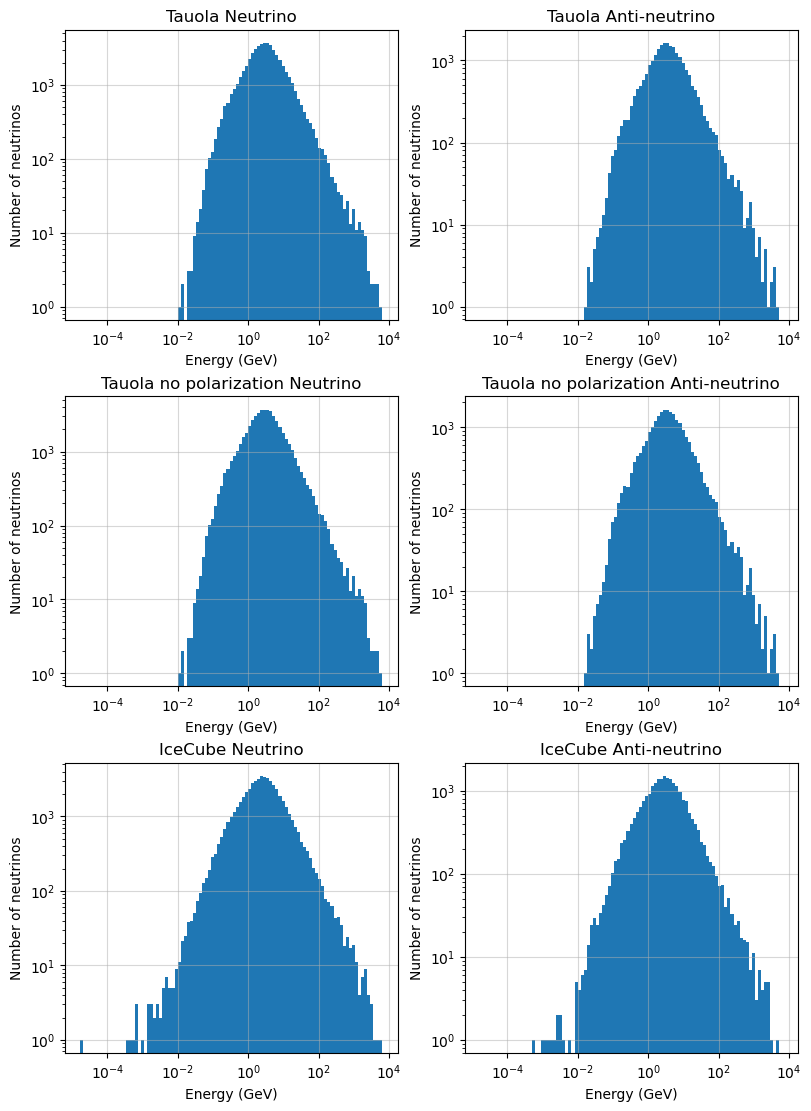

In [172]:
fig, axs = plt.subplots(figsize=(8, 11), nrows=3, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax_row, label, lists, in zip(axs, ("Tauola", "Tauola no polarization", "IceCube"), ((nutau_e, anti_nutau_e), (nutau_nopol_e, anti_nutau_nopol_e), (nutau_icecube_e, anti_nutau_icecube_e))):
    for ax, energies, particle_type in zip(ax_row, lists, ("Neutrino", "Anti-neutrino")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}")
        ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    # ax.legend(fontsize="large")

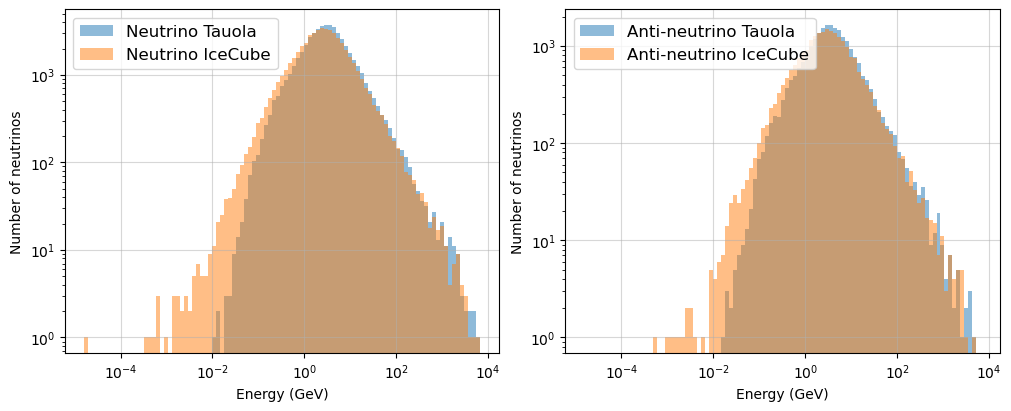

In [173]:
fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau_e, nutau_icecube_e), (anti_nutau_e, anti_nutau_icecube_e))):
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}", alpha=0.5)
        # ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

It seems like neutrinos tend to have lower energies for IceCube compared to Tauola. This would mean that the IceCube simulations overestimate the energy deposited in the detector.

## Low energy incoming tau neutrinos

In [29]:
# Select only events where the incoming neutrino has energy < 5 GeV
low_energy_events = particle_info.groupby("event_num").filter(lambda df: df.iloc[1, 2] < 5.)

In [30]:
decays_icecube_low_energy = decays_icecube[decays_icecube["event_num"].isin(low_energy_events["event_num"])]
nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == 16")["E"]
anti_nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == -16")["E"]

decays_low_energy = decay_products[decay_products["event_num"].isin(low_energy_events["event_num"])]
nutau_e_le = decays_low_energy.query("pdg == 16")["E"]
anti_nutau_e_le = decays_low_energy.query("pdg == -16")["E"]

/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: invalid value encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")


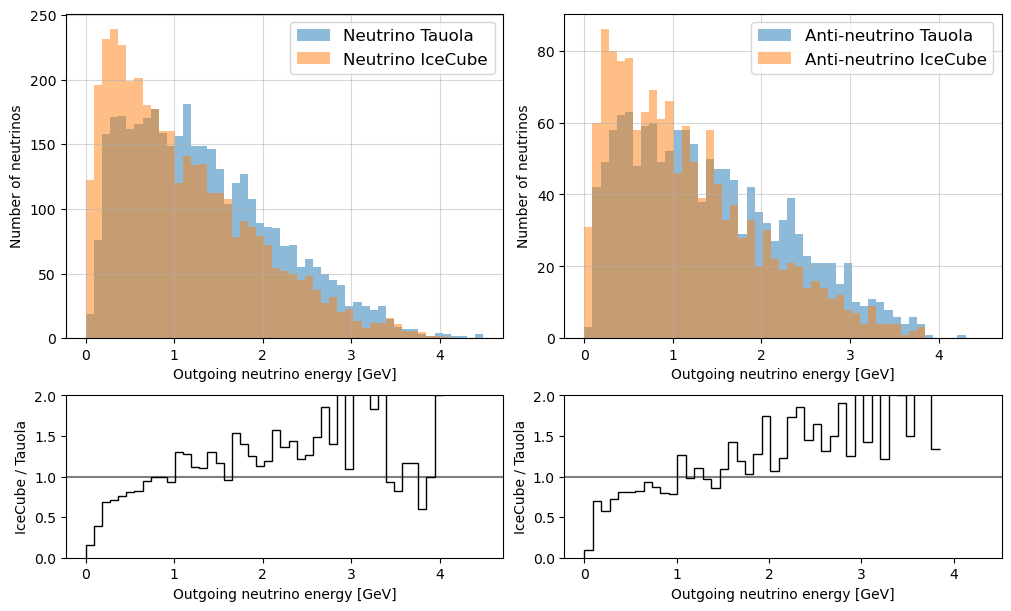

In [55]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=2, layout="constrained", gridspec_kw=dict(height_ratios=(2, 1)))

min_energy = np.min(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
max_energy = np.max(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
bins = np.linspace(min_energy, max_energy, 50)

histograms = []
for ax, label, lists, in zip(axs[0, :], ("Neutrino", "Anti-neutrino"), ((nutau_e_le, nutau_icecube_e_le), (anti_nutau_e_le, anti_nutau_icecube_e_le))):
    ax_hists = []
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        e_hist, *_ = ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5)
        ax_hists.append(e_hist)
        # ax.set_title(f"{label} {particle_type}")
    histograms.append(ax_hists)

for ax in axs[0, :]:
    ax.set(xlabel="Outgoing neutrino energy [GeV]", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

# Plot ratio of the histograms in the lower row
for ax, hist_list in zip(axs[1, :], histograms):
    ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
    ax.axhline(1, c="k", alpha=0.5)
    ax.set(ylim=(0, 2), xlabel="Outgoing neutrino energy [GeV]", ylabel="IceCube / Tauola")


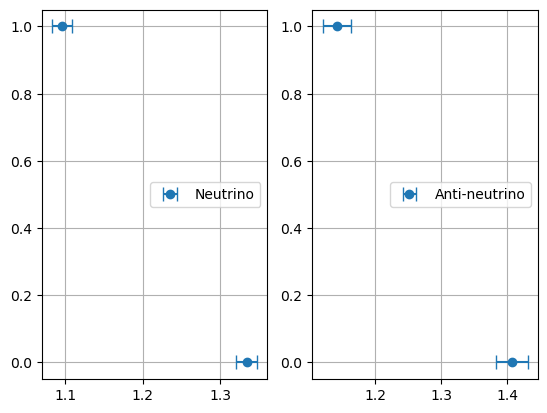

In [53]:
# Plot dots of mean energy with standard deviations. Each row should be a different dataset
# print(f"{np.mean(nutau_e)} +- {np.std(nutau_e)/np.sqrt(len(nutau_e)-1)}, {np.mean(nutau_icecube_e)} +- {np.std(nutau_icecube_e)/np.sqrt(len(nutau_e)-1)}")
fig, (ax, ax_anti) = plt.subplots(ncols=2)
ax.errorbar(
    y=np.arange(2),
    x=[np.mean(nutau_e_le), np.mean(nutau_icecube_e_le)],
    xerr=[np.std(nutau_e_le)/np.sqrt(len(nutau_e_le)-1), np.std(nutau_icecube_e_le)/np.sqrt(len(nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Neutrino"
)
ax.grid()
ax.legend(loc="center right")

ax_anti.errorbar(
    y=np.arange(2),
    x=[np.mean(anti_nutau_e_le), np.mean(anti_nutau_icecube_e_le)],
    xerr=[np.std(anti_nutau_e_le)/np.sqrt(len(anti_nutau_e_le)-1), np.std(anti_nutau_icecube_e_le)/np.sqrt(len(anti_nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Anti-neutrino"
)
ax_anti.grid()
ax_anti.legend(loc="center right")

For low energy primary tau neutrinos, the difference in mean energy is statistically significant between the two simulations. This couls mean that the spin polarization has a meaningful effect on the secondary neutrino energy.

In [57]:
particle_info.groupby("event_num").nth(1)

,event_num,pdg,E,px,py,pz
1,0,-16,3.730323,0.185260,3.295873,1.737299
6,1,16,3.725654,-1.656092,-2.943322,1.573121
13,2,16,3.528632,-2.419746,-2.330455,-1.079378
18,3,16,3.882620,-0.162095,-0.282077,-3.868966
25,4,16,3.909540,0.001797,-0.855136,-3.814871
...,...,...,...,...,...,...
447097,76638,-16,1420.859081,-563.321344,-862.807899,-978.300630
447103,76639,16,5830.060163,-5542.246831,-1435.699600,-1100.848866
447109,76640,-16,1898.861298,1372.595075,-1307.442511,-110.684538
447115,76641,16,2171.189851,-1055.061515,1112.683486,1537.155174


In [150]:
# Sort the events in particle_info based on the energy of the incoming neutrino
current_bin = 0
bin_step = 10
max_bin = 1000
bins = np.arange(current_bin, max_bin+bin_step+1e-6, bin_step)
bin_events = [[]]

for nu in particle_info.groupby("event_num").nth(1).sort_values("E").itertuples():
    if nu.E > current_bin + bin_step:
        current_bin += bin_step
        if current_bin > max_bin:
            break
        bin_events.append([])
    
    bin_events[-1].append(nu.event_num)

In [151]:
# For each energy bin, calculate the mean energy of the secondary neutrino

def get_energies(data, bin_events) -> tuple[list[float], list[float]]:
    mean_energies = []
    std_energies = []
    
    for events in bin_events:
        if len(events) <= 1:
            mean_energies.append(np.nan)
            std_energies.append(np.nan)
            continue

        decays = data[data["event_num"].isin(events)]
        mean_energies.append(np.mean(decays.query("abs(pdg) == 16")["E"]))
        std_energies.append(np.std(decays.query("abs(pdg) == 16")["E"])/np.sqrt(len(events)-1))
    return mean_energies, std_energies

# Tauola
mean_energies, std_energies = get_energies(decay_products, bin_events)
# IceCube
mean_energies_ic, std_energies_ic = get_energies(particle_info.groupby("event_num").nth[3:], bin_events)

In [152]:
len(mean_energies), len(bins)

(101, 102)

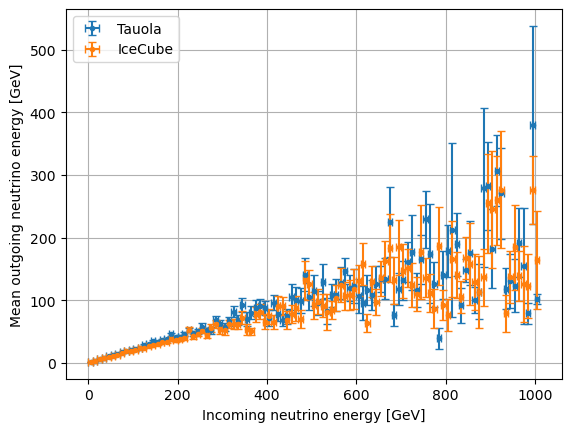

In [162]:
# Plot mean energies with standard deviations
fig, ax = plt.subplots()
plot_settings = dict(
    x=(bins[1:] + bins[:-1])/2,
    xerr=bin_step/2,
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=3,
    markersize=3,
)

ax.errorbar(
    y=mean_energies,
    yerr=std_energies,
    label="Tauola",
    **plot_settings,
)
ax.errorbar(
    y=mean_energies_ic,
    yerr=std_energies_ic,
    label="IceCube",
    **plot_settings,
)
ax.set(xlabel="Incoming neutrino energy [GeV]", ylabel="Mean outgoing neutrino energy [GeV]")
ax.legend()
ax.grid()

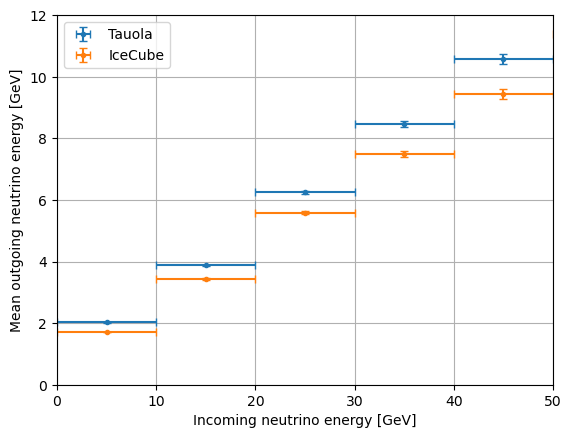

In [165]:
ax.set(xlim=(0, 50), ylim=(0, 12))
fig

Clearly for lower energies, the two decay simulations differ significantly from each other.

## Branching ratios for Tauola events

In [20]:
c = Counter(tuple(sorted(a.tolist())) for i, a in decay_products.groupby("event_num")["pdg"])

In [21]:
n_taus = (particle_info["pdg"] == 15).sum()
n_anti_taus = (particle_info["pdg"] == -15).sum()
n_taus, n_anti_taus

(53172, 23471)

In [22]:
br = {}
for pdgs, n in c.items():
    if 16 in pdgs:
        br[pdgs] = n / n_taus
    elif -16 in pdgs:
        br[pdgs] = n / n_anti_taus
    else:
        raise ValueError("No tau in the event")
br

{(-16, 211): 0.11000809509607601,
 (-211, 16, 111): 0.24992477243662078,
 (-211, 16): 0.1117505453998345,
 (-12, 11, 16): 0.1562288422477996,
 (-211, -211, 16, 211): 0.08920108327691266,
 (-16, 111, 211): 0.2545694687060628,
 (-211, -16, 211, 211): 0.08418899919049039,
 (-14, 13, 16): 0.17065372752576544,
 (-211, 16, 111, 111): 0.09294365455502897,
 (-16, -11, 12): 0.15593711388522005,
 (-211, -211, 16, 111, 211): 0.04500488979161965,
 (-16, -11, 12, 22): 0.028801499723062503,
 (-211, 16, 310): 0.0042315504400812455,
 (-16, -13, 14): 0.17148821950492096,
 (-211, 16, 130): 0.004269164221770857,
 (-211, -16, 111, 211, 211): 0.045630778407396363,
 (-211, 16, 130, 130): 0.00028210336267208303,
 (-16, 111, 111, 211): 0.09100592220186614,
 (-321, 16, 111): 0.004476040021063717,
 (-12, 11, 16, 22): 0.026724591890468666,
 (-211, 16, 111, 310): 0.003046716316858497,
 (-321, -211, 16, 211): 0.005134281200631911,
 (-321, -211, 16, 321): 0.0014857443767396373,
 (-211, -211, 16, 111, 111, 111, 211)

In [23]:
pdg2name = {15: "tau-", 16: "nu_tau", 211: "pi+", -15: "tau+", -16: "nu_tau_bar", -211: "pi-", 111: "pi0", 13: "mu-", -13: "mu+", 14: "nu_mu", -14: "nu_mu_bar", 11: "e-", -11: "e+", 12: "nu_e", -12: "nu_e_bar", 22: 
            "gamma", 310: "K^0_S", 130: "K^0_L", 321: "K+", -321: "K-"}

for pdgs, n in br.items():
    for pdg in pdgs:
        print(pdg2name[pdg], end=" ")
    print(":", n*100)

nu_tau_bar pi+ : 11.0008095096076
pi- nu_tau pi0 : 24.99247724366208
pi- nu_tau : 11.175054539983451
nu_e_bar e- nu_tau : 15.622884224779959
pi- pi- nu_tau pi+ : 8.920108327691265
nu_tau_bar pi0 pi+ : 25.456946870606277
pi- nu_tau_bar pi+ pi+ : 8.41889991904904
nu_mu_bar mu- nu_tau : 17.065372752576543
pi- nu_tau pi0 pi0 : 9.294365455502897
nu_tau_bar e+ nu_e : 15.593711388522005
pi- pi- nu_tau pi0 pi+ : 4.500488979161965
nu_tau_bar e+ nu_e gamma : 2.8801499723062505
pi- nu_tau K^0_S : 0.42315504400812454
nu_tau_bar mu+ nu_mu : 17.148821950492096
pi- nu_tau K^0_L : 0.42691642217708564
pi- nu_tau_bar pi0 pi+ pi+ : 4.563077840739636
pi- nu_tau K^0_L K^0_L : 0.028210336267208303
nu_tau_bar pi0 pi0 pi+ : 9.100592220186615
K- nu_tau pi0 : 0.44760400210637175
nu_e_bar e- nu_tau gamma : 2.6724591890468665
pi- nu_tau pi0 K^0_S : 0.3046716316858497
K- pi- nu_tau pi+ : 0.5134281200631912
K- pi- nu_tau K+ : 0.14857443767396372
pi- pi- nu_tau pi0 pi0 pi0 pi+ : 0.047017227112013844
nu_tau_bar pi0 p

KeyError: 221

In [24]:
# nutau_e = []
# anti_nutau_e = []
def identify_strange_events():
    with pyhepmc.open("tauola_output.dat", "r") as f:
        # Iterate over all events
        for i, evt in enumerate(f):
            # Find the tau and identify its daughter tau neutrino
            for vertex in evt.vertices:
                # Check if there is a tau neutrino as incoming particle
                # If it is, skip the vertex
                if any(np.abs(p.pid) == 16 for p in vertex.particles_in):
                    continue
                
                # Find the daughter tau neutrino
                for daughter in vertex.particles_out:
                    # If it is not a final state particle, skip it
                    if daughter.status != 1:
                        continue
                    
                    if np.abs(daughter.pid) not in {11, 12, 13, 14, 16, 111, 211, 22}:
                        return evt
                    
identify_strange_events()

<GenEvent momentum_unit=1, length_unit=0, event_number=32, particles=7, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>